# **Central bank communication & information overload: an empirical analysis of fed speeches and market reactions**

<u><strong>Author:</strong></u> Anaïs Augé & Alexandre Nonnenmacher

<u><strong>Course:</strong></u> Machine learning for Portfolio Management and Trading

<u><strong>Date:</strong></u> November 14, 2025


### **Setup and dependencies**

This notebook requires several Python packages to run correctly. The main dependencies are listed below. The following code cell automates the entire setup process: it checks for each required package and dynamically installs any that are missing from the current environment. 

**Required Packages:**
*   pandas
*   numpy
*   matplotlib
*   seaborn
*   nltk
*   scikit-learn
*   sentence-transformers
*   transformers
*   yfinance
*   selenium
*   webdriver-manager
*   requests
*   beautifulsoup4
*   umap-learn
*   statsmodels
*   xgboost
*   setuptools

In [147]:
import sys
import subprocess
import importlib

# Attempt to import pkg_resources 
try:
    import pkg_resources
except ImportError:
    print("Initial check failed: 'pkg_resources' not found. Attempting to install 'setuptools'...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "setuptools"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        import pkg_resources
        print("✓ 'setuptools' was missing and has been installed.")
    except Exception as e:
        print(f"FATAL: Could not install 'setuptools'. Please install it manually. Error: {e}")
        sys.exit(1)

# Required package
REQUIRED_PACKAGES = [
    "pandas", "numpy", "matplotlib", "seaborn", "nltk", "scikit-learn",
    "sentence-transformers", "transformers",
    "yfinance", "selenium", "webdriver_manager", "requests", "beautifulsoup4",
    "umap-learn", "statsmodels", "xgboost", "setuptools"
]

# Mapping to handle pip-name vs import-name differences
PACKAGE_MAP = {
    "sentence-transformers": "sentence_transformers",
    "beautifulsoup4": "bs4",
    "scikit-learn": "sklearn",
    "statsmodels": "statsmodels",
    "umap-learn": "umap",
}

def pip_install_silent(package):
    """Install a package via pip silently."""
    try:
        print(f"Installing missing package: {package} ...", end="", flush=True)
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )
        print("Done")
    except subprocess.CalledProcessError as e:
        print(f"FAILED. Error: {e}")
        print(f"Please install it manually using: pip install {package}")


def is_installed(package):
    """Check if a package (import name) is installed."""
    try:
        importlib.import_module(package)
        return True
    except ImportError:
        return False

print("Checking required Python packages...")

missing_packages = []
for pip_name in REQUIRED_PACKAGES:
    import_name = PACKAGE_MAP.get(pip_name, pip_name)
    if not is_installed(import_name):
        missing_packages.append(pip_name)

if missing_packages:
    print(f"{len(missing_packages)} package(s) are missing. Proceeding with installation.")
    for pkg in missing_packages:
        pip_install_silent(pkg)
    print("\nEnvironment setup complete.")
else:
    print("All required packages are already installed.")


# NLTK Check
try:
    from nltk.corpus import stopwords
    stopwords.words('english')
    print("NLTK 'stopwords' are available.")
except LookupError:
    print("NLTK 'stopwords' not found. Downloading...")
    import nltk
    import ssl
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context
    nltk.download('stopwords', quiet=True)
    print("✓ 'stopwords' downloaded successfully.")

Checking required Python packages...
All required packages are already installed.
NLTK 'stopwords' are available.


In [148]:
# Library imports: all necessary libraries for the project are imported here.

# Core data science & numerics 
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Data acquisition & web scraping 
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from selenium import webdriver 

# Natural Language Processing (NLP) 
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Machine learning & statistics 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import statsmodels.api as sm
import umap 
import xgboost as xgb

# System & utilities 
# (No other system imports needed here as they are in Cell 1)

# Set plot style for consistency 
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


## <u><strong>I. Introduction</strong></u>

#### **Contextual background**
Central bank communication has evolved into a primary tool for monetary policy. Speeches, press conferences, and testimonies from Federal Reserve (Fed) officials are closely monitored by financial markets to anticipate future decisions on interest rates, inflation, and economic growth. However, this reliance on communication has led to a widely observed trend: a marked increase in the frequency and volume of these public statements over the last decade. This escalation in communication raises a critical and compelling question that forms the core of our research: **can the Federal Reserve "talk too much"?**

This study investigates the hypothesis of *information overload* or *"communication fatigue".* We posit that beyond a certain threshold, the market's ability to process this communication changes. Instead of each speech triggering a distinct and meaningful market response, an excessive volume of communication, be it through high frequency, excessive repetition, or conflicting tones, could lead to a paradoxical outcome. Markets may begin to discount the information, leading to a diminished, null, or even counter-productive impact on asset prices and volatility. While much research confirms that central bank "news" moves markets, the non-linear effect of communication *intensity* and *saturation* remains an unanswered question.

#### **Project contributions**
This project addresses this gap by developing a quantitative framework to measure the intensity and redundancy of Fed communication and test its non-linear impact on market volatility. Our contributions are threefold:

1.  **Construction of a Communication Saturation Index (CSI):** We develop an index based on sentence embeddings (via SBERT) to quantify the semantic redundancy of messages over short horizons. This allows us to measure both intra-week message coordination and short-term repetition against recent communications.

2.  **Development of a Communication Intensity Index (CII):** We aggregate multiple dimensions of communication, including frequency, length, speaker diversity, tone (via FinBERT), and redundancy (CSI), into a single synthetic indicator using Principal Component Analysis (PCA). This provides a comprehensive weekly measure of "information pressure".

3.  **Empirical impact analysis of non-linear effects:** We employ a suite of econometric and machine learning models (OLS, ElasticNet, XGBoost) to rigorously test our central hypothesis. By explicitly modeling non-linear relationships, we investigate the existence of threshold and interaction effects between communication features (such as volume and speaker diversity) on market reactions (SPX, VIX, DXY) over short-term horizons.

#### **Summary of main empirical results**

Our empirical analysis provides nuanced support for our "communication fatigue" hypothesis, revealing a complex, non-linear relationship between Fed communication and market volatility. Our primary finding, derived from an OLS model with interaction and quadratic terms, shows statistically significant non-linear effects. Specifically, we find evidence of a threshold effect where the impact of the number of speeches on next-day VIX changes diminishes at high frequencies. We also identify an interaction effect, where a high number of different speakers is particularly volatility-inducing during weeks of already intense communication. Across our linear models (OLS and ElasticNet), the most stable and significant predictors of short-term volatility are the number of speeches, the diversity of speakers, and the tone of the communication. A crucial and consistent result across our models is the statistical insignificance of semantic redundancy (CSI) as a direct linear predictor. This suggests that the market is efficient at identifying and discounting repetitive information, a key tenet of the "communication fatigue" hypothesis. While the out-of-sample predictive power of our models is modest (with correlations around 0.1), which is expected in a noisy financial environment, the statistical significance of the non-linear relationships provides clear empirical support for the existence of communication overload effects.

#### **Literature and resource citations**
-   **Related academic papers:** 
    -   Hansen, S., & McMahon, M. (2016). *Shocking Language: Understanding the Macroeconomic Effects of Central Bank Communication*. Journal of International Economics.
    -   Ehrmann, M., & Talmi, J. (2020). *Starting from a blank page? Semantic similarity in central bank communication and market volatility*.
    -   Bulíř, A., Čihák, M., & Jansen, D. J. (2014). Does the Clarity of Inflation Reports Affect Volatility in Financial Markets? 
    -   Crayton, A. (2018). Central Bank Communication and the Yield Curve: A Semi-Automatic Approach using Non-Negative Matrix Factorization. 
    -   Ehrmann, M., & Talmi, J. (2020). Starting from a blank page? Semantic similarity in central bank communication and market volatility. 
    -   Hansen, S., McMahon, M., & Tong, M. (2019). The long-run information effect of central bank communication. 
    -   Silva, T. C., Moriya, K., & Veyrune, R. M. (2025). From Text to Quantified Insights: A Large-Scale LLM Analysis of Central Bank Communication. 
    -   Tutino, A. (2016). Central Bank Communication Must Overcome the Public's Limited Attention Span. Dallas Fed Economic Letter, 11(6).
-   **Software and resources:** 
    -   Data was scraped from the [Federal Reserve website](https://www.federalreserve.gov/newsevents/speeches.htm).
    -   Market data was sourced using the `yfinance` library.
    -   NLP analysis relied on `sentence-transformers`, `transformers` (Hugging Face), and `scikit-learn`.

## <u><strong>II. Dataset overview</strong></u>

#### **1. Data sources and composition**
The data used for this study are composed of two primary sources:

-   **Federal Reserve Speeches:** The textual data consists of a corpus of public speeches from members of the Federal Reserve Board of Governors, scraped from the Fed's official website. The dataset, `fed_speeches.csv`, covers the period from 1st November of 2011 to 1st November of 2025 and includes metadata such as the date, speaker, title, and word count. After a cleaning process to remove duplicates and speeches with fewer than 20 words, the corpus is prepared for analysis.
-   **Financial Market Data:** To measure market reactions, daily data for four key indices were downloaded using the `yfinance` library:
    -   **SPX (^GSPC):** S&P 500 index, representing the broad equity market.
    -   **VIX (^VIX):** CBOE Volatility Index, often termed the "fear index."
    -   **DXY (DX-Y.NYB):** U.S. Dollar Index, measuring its value against a basket of foreign currencies.

This section details the acquisition and key characteristics of both datasets to provide a comprehensive foundation for our analysis.

#### **2. Data acquisition**

To ensure full reproducibility, all data is acquired dynamically through the code in the following cells.

##### **2.1. Federal Reserve speeches (Web Scraping)**

The following cells will dynamically create and execute a Python script (scraping.py) to scrape the Federal Reserve speeches. This process populates the fed_speeches.csv file, which contains the full text and metadata for each speech.

Note: The scraping process only needs to be run once. If the fed_speeches.csv file already exists in your environment, you can skip executing the next two cells.

In [149]:
%%writefile scraping.py

from __future__ import annotations

import csv, os, re, time, random
from datetime import datetime
from pathlib import Path
from urllib.parse import urljoin

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

import requests
from bs4 import BeautifulSoup, Tag
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

START_DATE = datetime(2011, 11, 1) 
END_DATE = datetime(2025, 11, 1)

BASE = "https://www.federalreserve.gov"
YEAR_URL = BASE + "/newsevents/speech/{year}-speeches.htm"

OUT_DIR = Path.cwd()
FULL_CSV  = OUT_DIR / "fed_speeches.csv"

# If a speech has fewer than 150 words, it will be reprocessed on the next run
REPROCESS_IF_WC_LT = 150

SPEECH_URL_RE = re.compile(r"/newsevents/speech/[a-z0-9-]*\d{8}[a-z]?\.htm$", re.I)
DATE_MMDDYYYY = re.compile(r"\b\d{1,2}/\d{1,2}/\d{4}\b")

def make_driver():
    opts = Options()
    opts.add_argument("--headless=new")     
    opts.add_argument("--no-sandbox")
    opts.add_argument("--disable-dev-shm-usage")
    opts.add_argument("--user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126 Safari/537.36")
    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service, options=opts)

def write_rows(path: Path, rows, header):
    if not rows: return
    file_exists = path.exists()
    with open(path, "a", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=header)
        if not file_exists:
            w.writeheader()
        w.writerows(rows)

def parse_date_from_text(txt: str):
    m = DATE_MMDDYYYY.search(txt or "")
    if not m: return ""
    try:
        dt = datetime.strptime(m.group(0), "%m/%d/%Y")
        return dt.strftime("%Y-%m-%d")
    except:
        return ""

def date_from_url(href: str):
    m = re.search(r'/(\d{8})[a-z]?\.htm$', href or "")
    if not m: return ""
    s = m.group(1)
    try:
        dt = datetime(int(s[:4]), int(s[4:6]), int(s[6:8]))
        return dt.strftime("%Y-%m-%d")
    except:
        return ""

def extract_speaker_from_block(text_block: str):
    if not text_block: return ""
    lines = [ln.strip() for ln in text_block.splitlines() if ln.strip()]
    for ln in lines:
        lo = ln.lower()
        if lo.startswith("by "): return ln[3:].strip()
        if "speaker:" in lo:     return ln.split(":",1)[1].strip()
        if any(k in ln for k in ["Chair", "Governor", "President", "Vice Chair"]):
            return ln.strip()
    return ""

def nearest_container(a_el):
    XPATHS = [
        "./ancestor::li[1]",
        "./ancestor::div[contains(@class,'row')][1]",
        "./ancestor::article[1]",
        "./parent::div"
    ]
    for xp in XPATHS:
        try:
            c = a_el.find_element(By.XPATH, xp)
            if c and c.text.strip():
                return c
        except:
            pass
    return a_el

def make_session():
    s = requests.Session()
    s.headers.update({
        "User-Agent": ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                       "AppleWebKit/537.36 (KHTML, like Gecko) "
                       "Chrome/126.0 Safari/537.36")
    })
    retry = Retry(total=5, backoff_factor=0.5,
                  status_forcelist=(429,500,502,503,504),
                  allowed_methods=("GET",))
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.mount("http://",  HTTPAdapter(max_retries=retry))
    return s

WS_RE   = re.compile(r"\s+")
WORD_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ0-9’']+")
FOOTNOTE_ANCHOR = re.compile(r"^fn\d+$", re.I)

def clean_text(t:str) -> str:
    return WS_RE.sub(" ", t).strip()

def count_words(t:str) -> int:
    return len(WORD_RE.findall(t))

def _good_para_text(t:str) -> bool:
    if not t: return False
    low = t.lower()
    if "watch live" in low or low.startswith("share"): return False
    if t == "PDF": return False
    return count_words(t) >= 25

def _score_candidate(div: Tag) -> int:
    score = 0
    for p in div.find_all("p"):
        if p.find("a", attrs={"name": FOOTNOTE_ANCHOR}): 
            continue
        txt = p.get_text(" ", strip=True)
        if _good_para_text(txt):
            score += 1
    return score

def _pick_main_body(root: Tag) -> Tag:
    candidates = []
    selectors = [
        "#content div.col-xs-12.col-sm-8.col-md-8",
        "#content div.col-sm-8.col-md-8",
        "#content div.col-sm-8",
        "#content article",
        "div.col-xs-12.col-sm-8.col-md-8",
        "div.col-sm-8.col-md-8",
        "div.col-sm-8",
        "article",
    ]
    seen = set()
    for sel in selectors:
        for div in root.select(sel):
            if id(div) in seen: 
                continue
            seen.add(id(div))
            candidates.append(div)
    return max(candidates, key=_score_candidate) if candidates else root

def extract_transcript(html: str) -> str:
    soup = BeautifulSoup(html, "html.parser")
    root = soup.select_one("#content") or soup
    body = _pick_main_body(root)
    stop = root.select_one("#lastUpdate")

    parts = []
    for p in body.find_all("p", recursive=True):
        if stop and (p is stop or stop in p.parents):
            break
        if p.find("a", attrs={"name": FOOTNOTE_ANCHOR}):
            continue
        txt = p.get_text(" ", strip=True)
        if _good_para_text(txt):
            parts.append(txt)

    if not parts:  
        for p in body.find_all("p", recursive=True):
            if stop and (p is stop or stop in p.parents):
                break
            if p.find("a", attrs={"name": FOOTNOTE_ANCHOR}):
                continue
            txt = p.get_text(" ", strip=True)
            if count_words(txt) >= 5:
                parts.append(txt)

    text = " ".join(parts)
    text = re.sub(r"\s*\[\d+\]\s*", " ", text)
    text = re.sub(r"\s*\(\d+\)\s*", " ", text)
    return clean_text(text)

def scrape_and_process_speeches():
    """
    Scrapes Federal Reserve speeches for a given period and saves all data
    directly into a single CSV file.
    """
    print(f"Starting scraper for the period from {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
    print(f"Output file will be: {FULL_CSV}")

    done_urls = set()
    if FULL_CSV.exists():
        with open(FULL_CSV, "r", encoding="utf-8") as f:
            for r in csv.DictReader(f):
                url = (r.get("url") or "").strip()
                if not url: continue
                try:
                    wc = int(r.get("word_count") or 0)
                    if wc >= REPROCESS_IF_WC_LT:
                        done_urls.add(url)
                except ValueError:
                    continue
    print(f"Found {len(done_urls)} already processed and valid speeches.")

    driver = make_driver()
    session = make_session()
    
    header = ["date", "title", "speaker", "url", "word_count", "text"]
    batch, total_new_speeches = [], 0

    # Iterate through the years, from most recent to oldest
    for year in range(END_DATE.year, START_DATE.year - 1, -1):
        year_url = YEAR_URL.format(year=year)
        print(f"\n[Indexing Year {year}] {year_url}")
        
        try:
            driver.get(year_url)
            WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a")))
            time.sleep(0.5)
        except Exception as e:
            print(f"[WARNING] Could not load the page for year {year}: {e}")
            continue

        anchors = driver.find_elements(By.CSS_SELECTOR, "a[href^='/newsevents/speech/'][href$='.htm']")
        
        for a in anchors:
            try:
                href = a.get_attribute("href") or ""
                if not SPEECH_URL_RE.search(href):
                    continue

                full_url = urljoin(BASE, href)
                if full_url in done_urls:
                    continue
                
                # Date validation 
                cont_for_date = nearest_container(a)
                date_str = parse_date_from_text(cont_for_date.text) or date_from_url(href)
                if not date_str:
                    continue
                
                speech_date = datetime.strptime(date_str, "%Y-%m-%d")
                if not (START_DATE <= speech_date <= END_DATE):
                    continue
                print(f"Processing: {full_url}")
                
                resp = session.get(full_url, timeout=30)
                resp.raise_for_status()
                
                text = extract_transcript(resp.text)
                wc = count_words(text)
                
                ctx_text = cont_for_date.text if cont_for_date else ""

                row = {
                    "date": date_str,
                    "title": (a.text or a.get_attribute("title") or "").strip(),
                    "speaker": extract_speaker_from_block(ctx_text),
                    "url": full_url,
                    "word_count": wc,
                    "text": text
                }
                
                batch.append(row)
                total_new_speeches += 1
                done_urls.add(full_url) 

                # Write in batches to avoid keeping everything in memory
                if len(batch) >= 20:
                    write_rows(FULL_CSV, batch, header=header)
                    print(f"batch of {len(batch)} speeches written to CSV (new total: {total_new_speeches})")
                    batch = []
                
                time.sleep(random.uniform(0.1, 0.2))

            except Exception as e:
                # print(f"  [WARNING] Error on speech {href}: {e}")
                continue
    
    # Write the last batch if any remains
    if batch:
        write_rows(FULL_CSV, batch, header=header)
        print(f"final batch of {len(batch)} speeches written to CSV (new total: {total_new_speeches})")

    driver.quit()
    print(f"\nScraping complete. {total_new_speeches} new speeches were added.")


def main():
    # To ensure starting from scratch, to delete the old file: 
    # if FULL_CSV.exists():
    #     print(f"Deleting old file: {FULL_CSV}")
    #     os.remove(FULL_CSV)

    scrape_and_process_speeches()

    print(f"\nFinal CSV file created/updated at: {FULL_CSV}")

if __name__ == "__main__":
    main()

Overwriting scraping.py


In [150]:
# Execute the scraping script
# Note: This may take several minutes.
!python scraping.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Starting scraper for the period from 2011-11-01 to 2025-11-01
Output file will be: /Users/anaisauge/Desktop/projet /fed_speeches.csv
Found 885 already processed and valid speeches.

[Indexing Year 2025] https://www.federalreserve.gov/newsevents/speech/2025-speeches.htm
Processing: https://www.federalreserve.gov/newsevents/speech/kugler20250407a.htm

[Indexing Year 2024] https://www.federalreserve.gov/newsevents/speech/2024-speeches.htm

[Indexing Year 2023] https://www.federalreserve.gov/newsevents/speech/2023-speeches.htm

[Indexing Year 2022] https://www.federalreserve.gov/newsevents/speech/2022-speeches.htm
Processing: https://www.federalreserve.gov/newsevents/speech/waller20220218a.htm

[Indexing Year 2021] https://www.federalreserve.gov/newsevents/speech/2021-speeches.htm

[Indexing Year 2020] https://www.federalreserve.gov/newsevents/speech/2020-speeches.htm

[Indexing Year 2019] https://www.federalreserve.gov/newsevents/speech/2019-speeches.htm

[Indexing Year 2018] https://www.

In [151]:
# Load speeches 
speeches = pd.read_csv("fed_speeches.csv", parse_dates=["date"]).sort_values("date")

# Basic cleaning
speeches = speeches.drop_duplicates(subset=["url", "date", "speaker"])
speeches["word_count"] = pd.to_numeric(speeches.get("word_count"), errors="coerce")
speeches = speeches.dropna(subset=["text", "date", "speaker"])
speeches = speeches[speeches["text"].str.len() > 30]
speeches = speeches[speeches["word_count"] > 20].reset_index(drop=True)

# Time keys
speeches["year"]  = speeches["date"].dt.year
speeches["month"] = speeches["date"].dt.to_period("M").dt.to_timestamp("M")
speeches["week"]  = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

##### **2.2. Financial market data (API download)**

Once the speech corpus is created, we download the corresponding daily market data from Yahoo Finance using the yfinance library.
The time period for this data is dynamically determined by the start and end dates of our scraped speeches corpus, ensuring chronological consistency and data availability for our entire sample.

In [152]:
# Define tickers
tickers = {"SPX": "^GSPC", "VIX": "^VIX", "DXY": "DX-Y.NYB"}

# Define the date range for market data based on the speeches' dates
start_date = speeches["date"].min() - pd.Timedelta(days=7)
end_date   = speeches["date"].max() + pd.Timedelta(days=7)

print(f"Downloading market data from {start_date.date()} to {end_date.date()}...")

# Load daily closing prices
market_daily = yf.download(list(tickers.values()), start=start_date, end=end_date)['Close']
market_daily.columns = list(tickers.keys())
market_daily = market_daily.reset_index()
market_daily.rename(columns={'Date': 'date'}, inplace=True)
market_daily['date'] = pd.to_datetime(market_daily['date'])
market_daily.to_csv("market_data_daily.csv", index=False)

print("Market data downloaded successfully.")
market_daily.head()

[*********************100%***********************]  3 of 3 completed

Market data downloaded successfully.


,date,SPX,VIX,DXY
0,2011-10-28,75.089996,1285.089966,24.530001
1,2011-10-31,76.169998,1253.300049,29.959999
2,2011-11-01,77.260002,1218.280029,34.770000
3,2011-11-02,77.010002,1237.900024,32.740002
4,2011-11-03,76.669998,1261.150024,30.500000


#### **3. Descriptive statistics**

##### **3.1. The speeches corpus**

A descriptive exploration of the speeches corpus helps us understand the dynamics of Fed communication. We analyze who speaks, when, how often, and at what pace.

Yearly summary:
       n_speeches      avg_wc  n_speakers
year                                    
2021          68 2322.838235           8
2022          45 2188.088889           9
2023          95 2090.768421           8
2024         104 2498.903846           8
2025         104 2302.451923          12

Top speakers:
                                 n_speeches      avg_wc
speaker                                               
Governor Michelle W. Bowman            116 2503.068966
Governor Lael Brainard                  99 2710.101010
Governor Christopher J. Waller          70 2402.842857
Chair Jerome H. Powell                  61 1458.704918
Governor Jerome H. Powell               50 2351.700000
Vice Chairman Stanley Fischer           45 2913.644444
Chair Janet L. Yellen                   44 2737.136364
Governor Lisa D. Cook                   42 2050.095238
Vice Chair Richard H. Clarida           39 2331.923077
Chairman Ben S. Bernanke                36 2679.611111


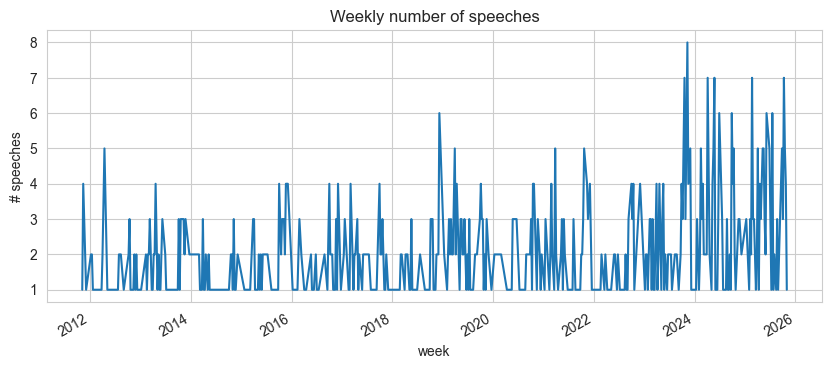

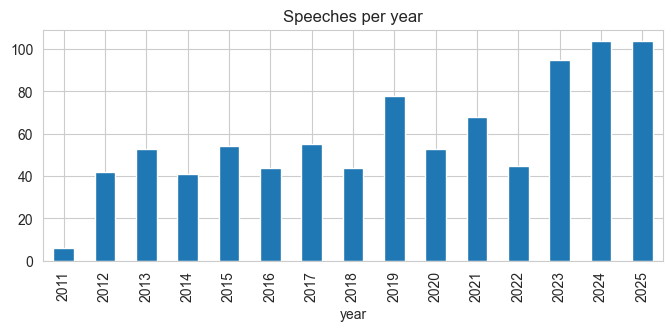

Correlation (# speeches vs avg length): r = -0.02 (p-value = 0.65)


In [153]:
# Basic yearly and speaker stats
by_year = speeches.groupby("year").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)
by_speaker = speeches.groupby("speaker").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean")
).sort_values("n_speeches", ascending=False).head(10)

print("Yearly summary:\n", by_year.tail())
print("\nTop speakers:\n", by_speaker)

# Weekly and monthly cadence
weekly = speeches.groupby("week").agg(
    n_speeches=("text", "count"),
    avg_wc=("word_count", "mean"),
    n_speakers=("speaker", "nunique")
)

# Plots
weekly["n_speeches"].plot(figsize=(10,4), title="Weekly number of speeches", ylabel="# speeches")
plt.show()

by_year["n_speeches"].plot(kind="bar", figsize=(8,3), title="Speeches per year")
plt.show()

# Correlation check with statistical significance
corr_coef, p_value = pearsonr(weekly["n_speeches"], weekly["avg_wc"])

print(f"Correlation (# speeches vs avg length): r = {corr_coef:.2f} (p-value = {p_value:.2f})")

<u><strong>Key observations:</strong></u>
- The number of speeches per year has increased notably, motivating our investigation into information overload.
- Communication is concentrated among a few key governors.
- The correlation between the number of weekly speeches and their average length is extremely weak (r = –0.02) and statistically insignificant (p = 0.65). This result provides no evidence that the Fed delivers shorter or more concise messages during weeks of intense communication activity. As a consequence, when communication frequency rises while average length remains stable, the total communication volume mechanically increases. This increase in volume, likely concentrated on a finite set of recurring policy themes, suggests a higher risk of message repetition and informational redundancy. 

These findings justify the need to move beyond raw frequency metrics and motivate the construction of our Communication Saturation Index (CSI), which explicitly captures semantic overlap and informational crowding

##### **Preliminary lexical analysis**

Before applying complex semantic models, a preliminary lexical analysis provides a foundational understanding of the corpus. The goal is to answer two key questions: what are the dominant topics in the Fed's communication? and how has the focus on these topics shifted over time? This analysis serves to validate our dataset by ensuring it reflects known macroeconomic events and provides an initial map of the topics where communication saturation is most likely to occur.

<u><strong>Methodology:</strong></u> Our approach consists of several key steps:
1. Text cleaning and tokenization: each speech is processed to create a "clean" list of meaningful words (tokens). This involves converting text to lowercase, removing all punctuation and numbers, and filtering out common English "stopwords" (e.g., 'the', 'a', 'is') which carry little analytical value. This ensures our analysis focuses on substantive terms.
2. Frequency calculation: we count the occurrences of each token. This is done both for the entire corpus (to identify globally important words) and on a year-by-year basis (to track changes).
3. Normalization for comparability: a simple word count can be misleading, as years with more speeches would naturally have higher counts for every word. To enable a fair comparison across years, we normalize the count of each word by the total number of tokens in that year. The result is a percentage (freq_pct), representing that word's share of the total discourse for a given year.
4. Selection of dynamic terms: instead of focusing on words that are always frequent, we are more interested in terms whose usage changes significantly over time. We identify these by calculating the variance of each word's frequency percentage across the years. The words with the highest variance are the most informative indicators of the Fed's shifting priorities

In [154]:
STOPWORDS = set(stopwords.words("english"))                                     # Convert everything to lowercase (case-insensitive analysis)
def clean_text(txt):
    txt = str(txt).lower()
    txt = re.sub(r"[^a-z\s]", " ", txt)                                         # Remove punctuation, numbers, and symbols
    return [w for w in txt.split() if w not in STOPWORDS and len(w) > 2]        # Split text into individual words (“tokens”), remove useless common words (“the”, “and”, “of”…) and remove ultra-short tokens like “a”, “us”, “it”

speeches["tokens"] = speeches["text"].apply(clean_text)
speeches["year"] = speeches["date"].dt.year

# Top frequent words per year : group all speeches from the same year, merge all their tokens and find the most common words 
def top_words_by_year(df, n=10):
    return (
        df.groupby("year")["tokens"]
          .apply(lambda x: Counter([w for tokens in x for w in tokens]).most_common(n))
    )

# Flatten yearly top words to a tidy DataFrame
records = []
top_words = top_words_by_year(speeches, n=15)
for year, lst in top_words.items():
    for word, count in lst:
        records.append((int(year), word, int(count)))

df_top = pd.DataFrame(records, columns=["year", "word", "count"]).sort_values(["year","count"], ascending=[True, False]) 

# Normalize by total tokens per year (so years are comparable)
year_totals = (
    speeches.groupby("year")["tokens"]
            .apply(lambda toks: sum(len(t) for t in toks))
            .rename("year_token_total")
)
df_top = df_top.merge(year_totals, on="year", how="left")
df_top["freq_pct"] = 100 * df_top["count"] / df_top["year_token_total"]

# Quick global word frequency: this merges all speeches together, giving the 30 most frequent words in the full dataset:
all_words = [w for tokens in speeches["tokens"] for w in tokens]
freq = Counter(all_words).most_common(30)
pd.DataFrame(freq, columns=["word", "count"]).head(10)

,word,count
0,financial,11527
1,policy,10484
2,inflation,10119
3,banks,8842
4,federal,8218
5,market,7063
6,rate,6913
7,bank,6573
8,percent,6363
9,reserve,6049


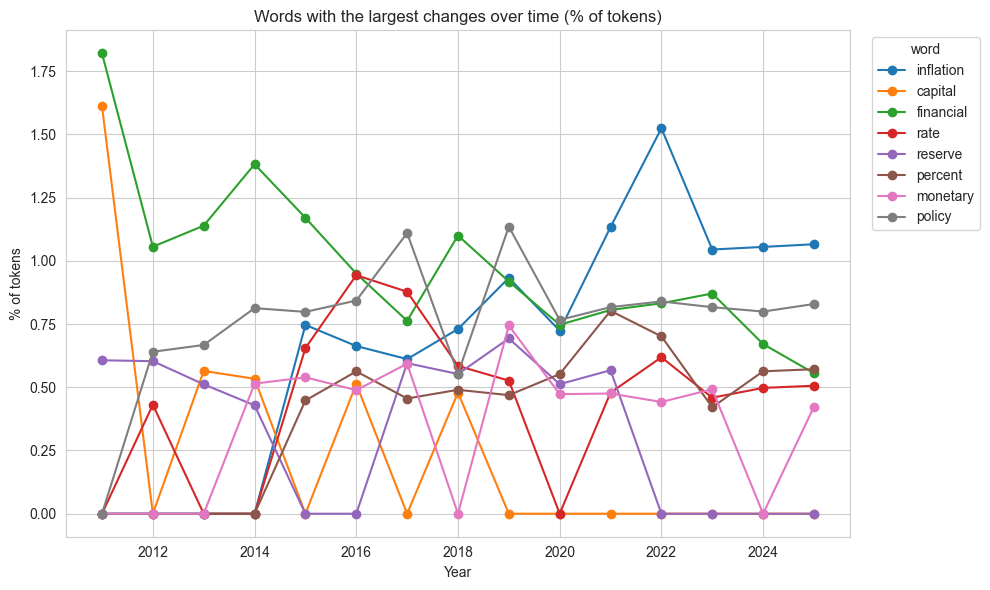

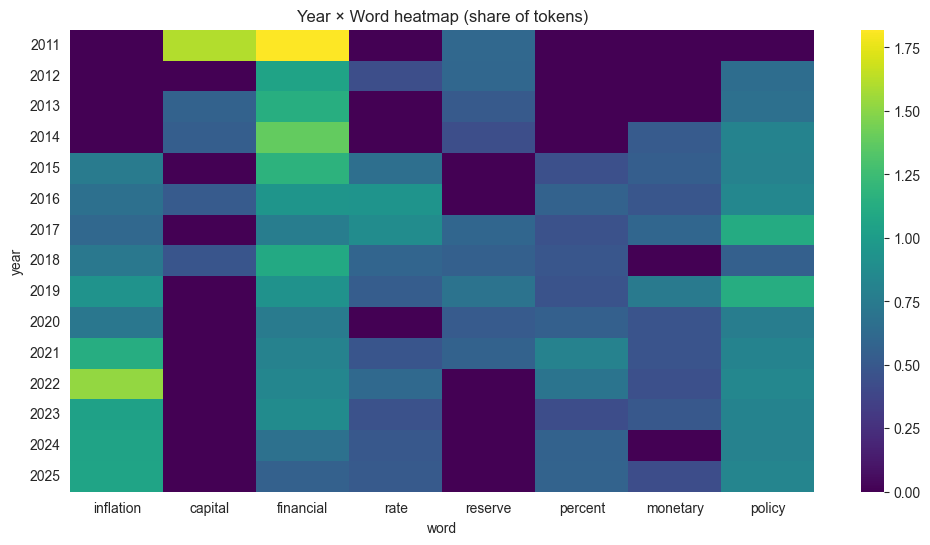

In [155]:
# Pivot to year x word matrix of % frequencies
mat = df_top.pivot_table(index="year", columns="word", values="freq_pct", fill_value=0)

# Pick words with largest variance over years
top_var_words = mat.var().sort_values(ascending=False).head(8).index.tolist()

mat[top_var_words].plot(figsize=(10,6), marker="o")
plt.title("Words with the largest changes over time (% of tokens)")
plt.xlabel("Year"); plt.ylabel("% of tokens"); plt.legend(title="word", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(mat[top_var_words], cmap="viridis")
plt.title("Year × Word heatmap (share of tokens)")
plt.xlabel("word"); plt.ylabel("year")
plt.show()

<u><strong>Key observations:</strong></u>
- Words like "inflation," "policy," and "labor" exhibit significant temporal variance, with "inflation" becoming particularly dominant post-2021, aligning with the macroeconomic context.
- This preliminary analysis highlights the changing focus of the Fed's narrative over the years.

##### 3.2. Financial market dynamics

An overview of the market data provides context for the period under study. The following visualizations show the evolution and relationships of the key indices.

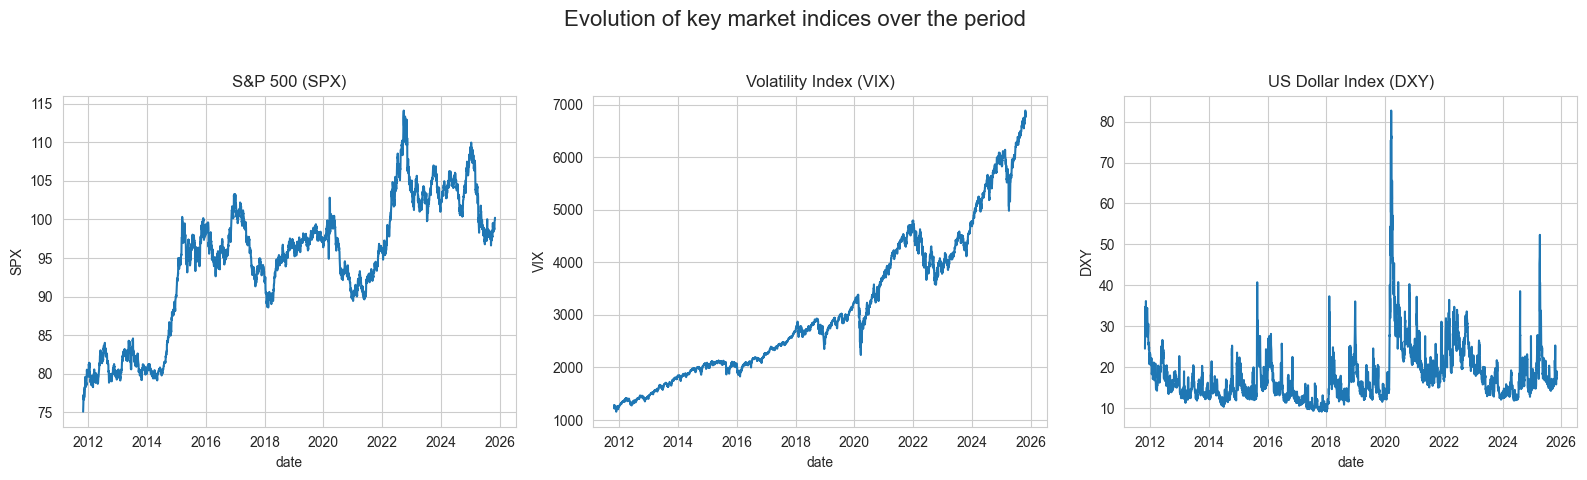

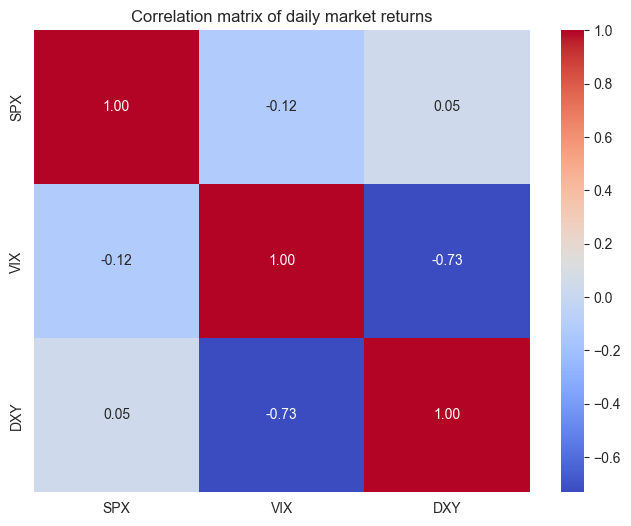

In [156]:
# Plot the evolution of the market indices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Evolution of key market indices over the period', fontsize=16)

sns.lineplot(ax=axes[0], data=market_daily, x='date', y='SPX').set_title('S&P 500 (SPX)')
sns.lineplot(ax=axes[1], data=market_daily, x='date', y='VIX').set_title('Volatility Index (VIX)')
sns.lineplot(ax=axes[2], data=market_daily, x='date', y='DXY').set_title('US Dollar Index (DXY)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Calculate daily returns for correlation analysis
market_returns = market_daily[list(tickers.keys())].pct_change().dropna()

# Plot a correlation matrix of the daily returns
plt.figure(figsize=(8, 6))
sns.heatmap(market_returns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix of daily market returns')
plt.show()

<u><strong>Key observations:</strong></u>

The plots above show the trajectory of the four market indices over our sample period. We can observe several market regimes, including periods of high volatility and strong trends in the equity and bond markets. This highlights the diverse market conditions in which Fed communications occurred.

The heatmap reveals the relationships between the daily movements of the indices. As expected, we observe a strong negative correlation between the SPX and the VIX, confirming the VIX's role as a 'fear gauge'. The correlations between other assets, such as the DXY and TNX, provide insights into the broader macroeconomic environment.

## <u><strong>III. Analytics and learning strategies</strong></u>

To test our hypothesis of information overload, we must first deconstruct the raw text of Fed speeches into a set of quantifiable features. This section outlines our methodology for transforming unstructured text into structured data. We proceed in three stages: first, identifying key themes and their evolution (TF-IDF and Semantic Clustering), second, quantifying the affective tone of each message (FinBERT), and finally, aggregating these features into our proposed Communication Saturation Index (CSI) and Communication Intensity Index (CII).

#### **1. Semantic and thematic analysis**

**a. Discriminative terms (TF-IDF)**

Our first analytical step is to identify the most characteristic terms of specific time periods and speakers. For this, we use the **Term Frequency-Inverse Document Frequency (TF-IDF)** weighting scheme.

Unlike a simple word count that highlights common words like "economy" or "policy," TF-IDF is designed to find words that are unusually important to a specific speech or group of speeches. It works like a "surprise detector" for words.

The core idea is to give a high score to a word if it appears much more often in a particular speech than it does on average across all other speeches.

*   A generic word like "economy" will get a low score. Even if it's used 20 times in one speech, it's also used frequently in all the others, so its presence isn't special.
*   A specific, timely word like "pandemic" in a 2020 speech will get a very high score. It appears very frequently in speeches from that period, but was almost absent in speeches from 2015. Its high frequency is therefore "surprising" and characteristic of that specific time.

This feature makes TF-IDF excellent for:
- filtering out noise: Focusing only on terms that truly discriminate one speech from another.
- mapping the Shifting Lexicon: By grouping speeches by year, TF-IDF reveals the evolving concerns of the Fed (e.g., from 'mortgage' in 2011 to 'crypto' in 2023).
- speaker Profiling: Identifying the unique vocabulary of specific Governors, which is essential for understanding potential message divergence.

The analysis is based on 1-grams and 2-grams (single words and common two-word phrases) to capture basic conceptual units.

In [157]:
speeches = speeches.copy()
speeches["year"] = speeches["date"].dt.year

# Build TF-IDF (1-2 grams, light pruning)
vectorizer = TfidfVectorizer(
    lowercase=True, stop_words="english",
    ngram_range=(1,2), min_df=5, max_df=0.9
)
X = vectorizer.fit_transform(speeches["text"].fillna(""))
terms = np.array(vectorizer.get_feature_names_out())

def top_tfidf_for_groups(group_col, topk=15, min_group_size=5):
    out = {}
    for g, idx in speeches.groupby(group_col).indices.items():
        if len(idx) < min_group_size: 
            continue
        avg = np.asarray(X[idx].mean(axis=0)).ravel()
        top_idx = np.argsort(avg)[::-1][:topk]
        out[g] = list(zip(terms[top_idx], avg[top_idx]))
    return out

top_by_year = top_tfidf_for_groups("year", topk=15, min_group_size=5)
top_by_speaker = top_tfidf_for_groups("speaker", topk=15, min_group_size=5)

for year, words in sorted(top_by_year.items()):
    print(f"\n{year}")
    print(", ".join([w for w, _ in words]))


2011
financial, capital, basel, firms, military, small, basel iii, iii, systemic, basel committee, economies, asian, requirements, small businesses, small business

2012
banks, financial, community, mortgage, policy, term, housing, market, community banks, recovery, economic, lending, crisis, banking, rates

2013
financial, capital, policy, banks, market, term, crisis, risk, bank, asset, community, monetary, rate, economic, purchases

2014
financial, policy, banks, community, risk, monetary, capital, crisis, monetary policy, market, firms, community banks, bank, rate, regulatory

2015
financial, inflation, policy, market, rate, banks, monetary, crisis, liquidity, monetary policy, capital, institutions, community, percent, markets

2016
rate, inflation, financial, growth, policy, percent, productivity, market, monetary, labor, monetary policy, rates, economic, capital, economy

2017
policy, rate, inflation, financial, monetary, monetary policy, rates, market, banks, economic, percent, 

In [158]:
for spk, words in list(top_by_speaker.items())[:5]:
    print(f"\n{spk}")
    print(", ".join([w for w, _ in words]))


Chair Janet L. Yellen
inflation, rate, policy, financial, labor, economic, monetary, monetary policy, economy, percent, funds rate, fomc, market, community, women

Chair Jerome H. Powell
inflation, policy, percent, economy, monetary, labor, monetary policy, economic, pandemic, fed, market, growth, labor market, rate, time

Chairman Ben S. Bernanke
financial, banks, policy, economic, community, term, monetary, crisis, rates, market, bank, economy, banking, recovery, monetary policy

Chairman Jerome H. Powell
inflation, financial, unemployment, policy, economy, rural, monetary, rate, labor, communities, monetary policy, crisis, community, fed, growth

Governor Adriana D. Kugler
inflation, labor, percent, pandemic, supply, policy, workers, prices, data, growth, economic, labor market, expectations, goods, rate


The TF-IDF results clearly illustrate the Fed's evolving narrative. The vocabulary of the post-2008 crisis era (e.g., "basel iii", "systemic" in 2011) gradually gives way to concerns about "inflation", "labor", and the "pandemic" in the 2020s. This confirms that our text data accurately captures the macroeconomic context. More importantly for our study, it reveals that the Fed's communication is concentrated on a few dominant topics at any given time, creating the ideal conditions for potential message saturation.

**b. Semantic clustering (Embeddings + K-Means)**

While TF-IDF helps us find important keywords, it doesn't capture the overall "topic" of a speech. To group speeches by their core message, we use a more advanced semantic clustering approach. This is a two-step methodology designed to group similar speeches together, even if they use different wording.

**1. Feature extraction: transforming words into meaning (sentence embeddings)**

First, we need to represent the meaning of each speech numerically. For this, we use a pre-trained language model (`all-MiniLM-L6-v2`) to generate a **semantic embedding** for each speech.

*   An embedding is a high-dimensional vector (a list of numbers) that acts as a numerical fingerprint for the text's meaning. The model, trained on vast amounts of text, has learned to place texts with similar meanings close to each other in this vector space.

*   Unlike keyword-based methods such as TF-IDF, embeddings capture context and semantic similarity. For example a speech about *"the stability of our financial institutions" and a speech about *"ensuring the banking system is resilient"* will have very similar embedding vectors, even though they don't share many keywords. TF-IDF would see them as more different. This allows us to group speeches based on the ideas they convey, not just the words they use.

**2. Clustering: grouping similar speeches together (K-Means)**

Once every speech is represented by a numerical vector, we apply the **K-Means clustering algorithm**. This algorithm automatically groups the speech embeddings into **K** distinct thematic clusters. We chose K=6 after tested several values (ranging from K=4 to K=8). While quantitative methods like the Elbow method or Silhouette score can provide guidance, the ultimate goal of this analysis is thematic interpretability. We found that **K=6** provided the most meaningful and distinct set of topics. 

The purpose of this clustering step is twofold:
*   **Identify core themes:** it allows us to systematically classify the entire corpus into the major, recurring topics of Fed communication (e.g., Monetary Policy, Financial Regulation, etc.).
*   **Enable saturation measurement:** by assigning each speech to a theme, this grouping becomes a crucial input for our Communication Saturation Index (CSI), allowing us to quantify information overload by tracking how often the same theme appears in a short period.

In [159]:
texts = speeches["text"].fillna("").tolist()

# rebuild TF-IDF if needed
if "X" not in locals() or "terms" not in locals():
    vectorizer = TfidfVectorizer(lowercase=True, stop_words="english",
                                 ngram_range=(1,2), min_df=5, max_df=0.9)
    X = vectorizer.fit_transform(texts)
    terms = np.array(vectorizer.get_feature_names_out())

model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

K = 6
km = KMeans(n_clusters=K, n_init=10, random_state=42)
speeches["theme_cluster"] = km.fit_predict(emb)

def top_terms_for_cluster(cluster_id, topk=20):
    idx = speeches.index[speeches["theme_cluster"] == cluster_id].tolist()
    if not idx: return []
    avg = np.asarray(X[idx].mean(axis=0)).ravel()
    top_idx = np.argsort(avg)[::-1][:topk]
    return list(zip(terms[top_idx], avg[top_idx]))

cluster_terms = {c: top_terms_for_cluster(c, topk=20) for c in range(K)}
cluster_terms

# UMAP coords
try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
    coords_2d = reducer.fit_transform(emb)
    speeches["umap_x"] = coords_2d[:,0]
    speeches["umap_y"] = coords_2d[:,1]
except Exception:
    pass

Batches: 100%|██████████| 28/28 [00:21<00:00,  1.32it/s]


In [160]:
for c in sorted(cluster_terms.keys()):
    kw = ", ".join([w for w,_ in cluster_terms[c][:12]])
    print(f"Cluster {c}: {kw}")

Cluster 0: community, banks, community banks, communities, cra, bank, financial, banking, small, community development, development, credit
Cluster 1: inflation, policy, rate, monetary, monetary policy, labor, percent, fomc, market, economic, economy, rates
Cluster 2: economics, inflation, women, students, economic, education, economy, policy, life, labor, financial, pandemic
Cluster 3: inflation, percent, policy, labor, rate, growth, monetary, market, economy, monetary policy, year, labor market
Cluster 4: financial, capital, banks, stress, banking, bank, risk, regulatory, liquidity, firms, market, crisis
Cluster 5: payments, payment, ai, cbdc, innovation, financial, digital, technology, banks, crypto, stablecoins, bank


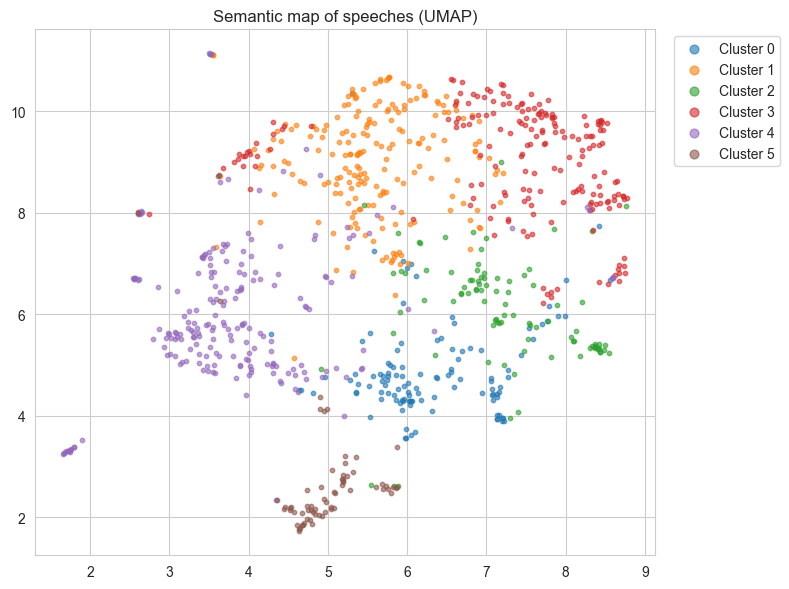

In [161]:
if {"umap_x","umap_y","theme_cluster"}.issubset(speeches.columns):
    plt.figure(figsize=(8,6))
    for c in sorted(speeches["theme_cluster"].unique()):
        m = speeches["theme_cluster"] == c
        plt.scatter(speeches.loc[m, "umap_x"], speeches.loc[m, "umap_y"], s=10, alpha=0.6, label=f"Cluster {c}")
    plt.title("Semantic map of speeches (UMAP)"); plt.legend(markerscale=2, bbox_to_anchor=(1.02,1), loc="upper left"); plt.tight_layout(); plt.show()

<u><strong>Key observations:</strong></u>

This scatter plot displays the high-dimensional speech embeddings projected onto a 2D plane using UMAP (Uniform manifold approximation and projection).
- Each point represents a single speech. The goal of the UMAP algorithm is to place speeches that are semantically close (i.e., discuss similar topics) near each other visually.
- The clear spatial separation of the different colored clusters (determined by K-Means) visually confirms the existence of distinct, internally coherent thematic groups within the Fed's communication. This provides confidence that our clustering accurately segments the corpus into meaningful themes.

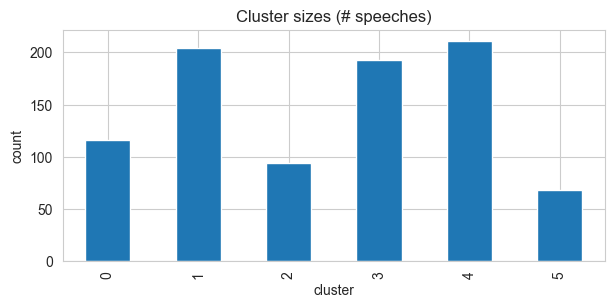

In [162]:
counts = speeches["theme_cluster"].value_counts().sort_index()
counts.plot(kind="bar", figsize=(7,3), title="Cluster sizes (# speeches)"); plt.xlabel("cluster"); plt.ylabel("count"); plt.show()

<u><strong>Key observations:</strong></u>

This bar chart shows the total number of speeches assigned to each theme.
The significant disparity in size, where a few clusters dominate the total speech count confirms that the majority of the Fed's public communication energy is concentrated on a small set of axes.
This concentration shows that the increase in the number of speeches (from Part II) is applied to an already narrow thematic focus, creating ideal structural conditions for message saturation.

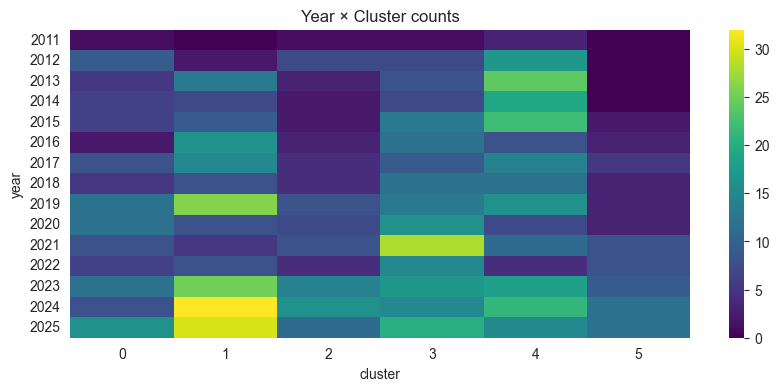

In [163]:
speeches["year"] = speeches["date"].dt.year
tab = pd.crosstab(speeches["year"], speeches["theme_cluster"])
plt.figure(figsize=(10,4)); sns.heatmap(tab, cmap="viridis"); plt.title("Year × Cluster counts"); plt.xlabel("cluster"); plt.ylabel("year"); plt.show()

<u><strong>Key observations:</strong></u>

This heatmap illustrates how the presence of each thematic cluster evolves over the years. Brighter colors indicate a higher number of speeches on that specific topic during that year.
The heatmap highlights the impact of external events, such as the clear dominance of specific clusters during periods like the post-2021 inflation surge.
This visualization confirms that the Fed's narrative is not static. It validates the need for an event-based approach that links market reactions to the contemporary communication features (intensity, saturation, tone) prevailing at that specific time, rather than assuming a single, constant relationship over the entire decade.

#### **2. Tonal Analysis (FinBERT)**
Beyond the topic of communication, the tone is a critical channel of information. A message can be diluted not only by thematic repetition but also by tonal inconsistency or saturation. To quantify this dimension, we use FinBERT, a state-of-the-art language model specifically fine-tuned on a large corpus of financial texts. This specialization makes it superior to generic sentiment models as it understands the specific nuances of market-related language.

FinBERT classifies each speech into one of three categories, representing its likely interpretation from an investor's perspective:
- Positive: a confident, reassuring, or optimistic tone regarding the economy, growth, monetary policy, or financial stability. The text suggests favorable conditions or successful policy outcomes (e.g., "inflation is returning to our target").
- Neutral: an informative, descriptive, or factual tone, without explicit judgment or emotion. As observed in our results, this is the default stance for the majority of Fed communications, which prize objectivity.
- Negative: a worried, cautious, or pessimistic tone, signaling economic risks, headwinds, or challenges (e.g., "significant uncertainty remains about the outlook").

This tonal classification provides a feature for our final Communication Intensity Index (CII), allowing us to test whether tonal saturation or conflict contributes to information overload.

**Note:** the following cell can take a significant amount of time to execute as it applies the language model to each speech in the corpus.

In [164]:
finbert = pipeline("sentiment-analysis",
                   model="yiyanghkust/finbert-tone",
                   tokenizer="yiyanghkust/finbert-tone")

# Example: sentiment of a text by adding a sentence just to test what it returns 
finbert("Inflation pressures remain elevated while growth slows.")

Device set to use mps:0


[{'label': 'Negative', 'score': 0.9999305009841919}]

Starting sentiment analysis (this may take some time)...
Sentiment analysis completed.

Enriched DataFrame successfully saved to 'speeches_with_nlp.csv'.

Preview of new columns:


,date,speaker,sentiment,tone_score
0,2011-11-04,Governor Daniel K. Tarullo,Neutral,0
1,2011-11-09,Chairman Ben S. Bernanke,Neutral,0
2,2011-11-09,Governor Daniel K. Tarullo,Negative,-1
3,2011-11-10,Chairman Ben S. Bernanke,Positive,1
4,2011-11-11,Vice Chair Janet L. Yellen,Positive,1


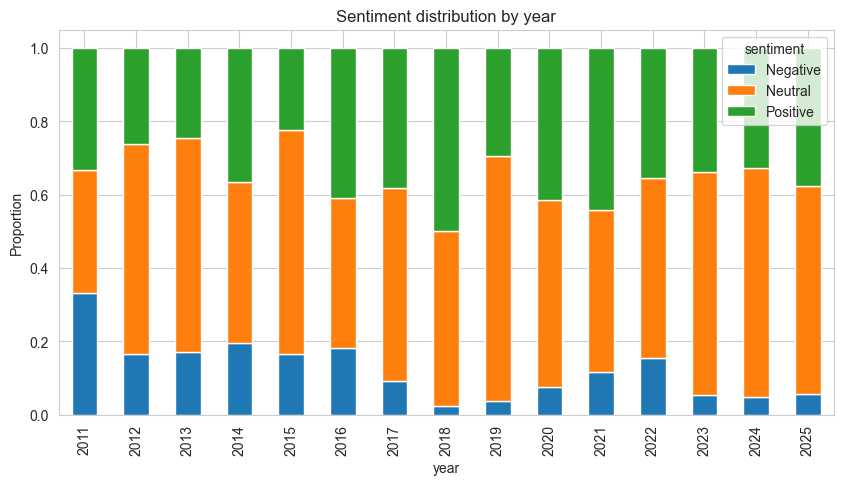

In [165]:
try:
    finbert_pipeline
except NameError:
    print("Initializing FinBERT pipeline...")
    finbert_pipeline = pipeline("sentiment-analysis",
                                model="yiyanghkust/finbert-tone",
                                tokenizer="yiyanghkust/finbert-tone")

print("Starting sentiment analysis (this may take some time)...")
if not speeches.empty:
    speeches["sentiment"] = speeches["text"].apply(lambda x: finbert_pipeline(x[:512])[0]['label'])
    print("Sentiment analysis completed.")

    sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    speeches['tone_score'] = speeches['sentiment'].map(sentiment_mapping)
    
    output_filename = "speeches_with_nlp.csv"
    speeches.to_csv(output_filename, index=False, encoding='utf-8')

    print(f"\nEnriched DataFrame successfully saved to '{output_filename}'.")
    print("\nPreview of new columns:")
    display(speeches[['date', 'speaker', 'sentiment', 'tone_score']].head())

    sentiment_by_year = pd.crosstab(speeches["year"], speeches["sentiment"], normalize="index")
    sentiment_by_year.plot(kind="bar", stacked=True, figsize=(10, 5), title="Sentiment distribution by year")
    plt.ylabel("Proportion")
    plt.show()
else:
    print("The 'speeches' DataFrame is empty. Please run the data loading cells first.")

<u><strong>Key observations:</strong></u>

The stacked bar chart reveals that Fed communication is predominantly 'Neutral', which aligns with the institution's formal and data-driven style. However, this neutrality is precisely why shifts towards 'Positive' or 'Negative' language are so significant for markets.

<u><strong>Conclusion:</strong></u>

The preceding analyses have successfully deconstructed the raw text of Fed speeches into a set of structured, quantifiable features. Our findings build a clear narrative arc:
- Descriptive Analysis in Part II revealed: "The Fed is talking more and more."
- Thematic Analysis in Part III a. and b. confirmed: "It's talking more and more about the same few core topics."

This evidence strongly supports the premise that Fed communication is susceptible to information saturation. The logical next step is therefore to quantitatively measure this redundancy and combine it with other communication metrics to build a comprehensive indicator of "information pressure". This is the objective of the Communication Saturation Index (CSI) and the Communication Intensity Index (CII) developed below.

#### **3. Communication Saturation Index (CSI) Construction**

The CSI is designed to quantify semantic redundancy in the Fed's communication. Leveraging the speech embeddings produced earlier, it measures message similarity across two complementary time axes. The calculation is based on the cosine similarity between the embedding vectors of two speeches (A and B):


$$\text{similarity}(A,B) = \cos(\theta) = \frac{A \cdot B}{\lVert A\rVert \,\lVert B\rVert}$$

This metric ranges from -1 (opposite meaning) to 1 (identical meaning), where 1 signifies perfect semantic similarity. We construct two weekly indicators:
- Intra-week Redundancy (csi_within_mean): Measures message coordination or duplication within the same week. It is the average cosine similarity across all pairs of speeches in a given week. A high score suggests a hammered, coordinated message.
- Short-term Repetition (csi_recent_maxavg): Captures the persistence or recycling of narratives. For each speech in a week, we find its closest semantic match in the preceding 8 weeks. The index is the average of these maximum similarities. A high score indicates low new information content compared to the recent past.

,csi_within_mean,csi_recent_maxavg,n_speeches
week,,,
2017-07-14,1.000000,0.554830,2
2017-02-24,NaN,0.936256,1
2015-02-06,NaN,0.905844,1
2024-08-16,NaN,0.892389,1
2016-11-04,NaN,0.855469,1
2024-05-03,NaN,0.838880,1
2021-05-14,0.699368,0.833725,3
2025-08-01,0.729393,0.831901,2
2019-05-03,NaN,0.827238,1


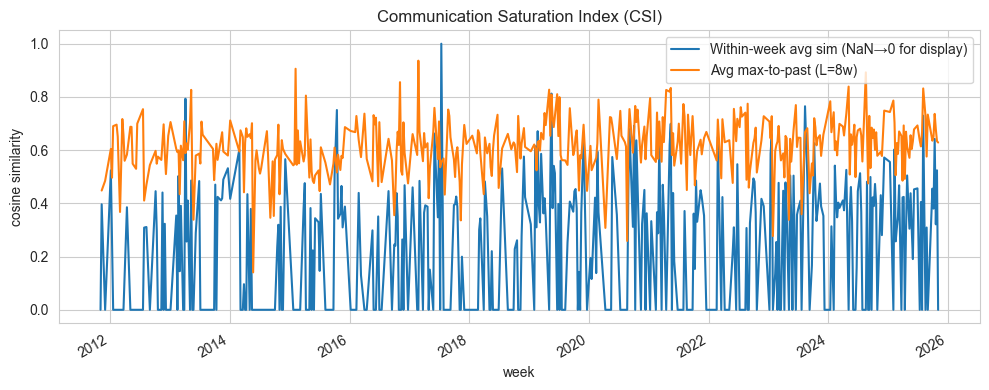

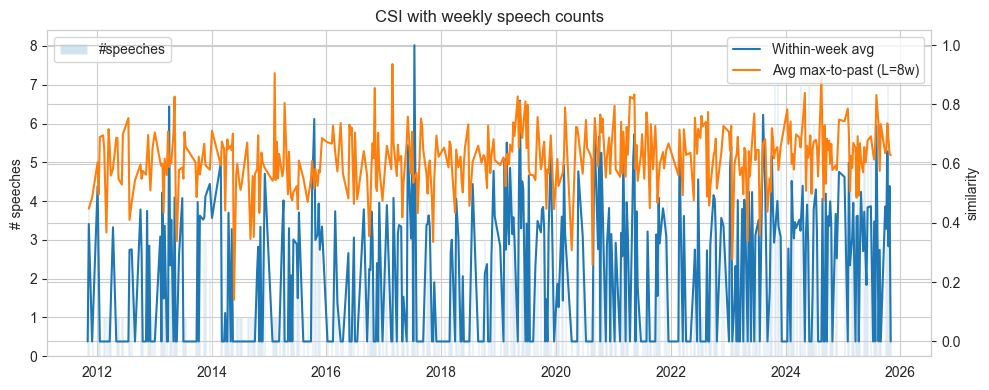

In [166]:
# Preconditions 
assert "date" in speeches.columns and "text" in speeches.columns, "speeches must have 'date' and 'text'."
speeches = speeches.sort_values("date").reset_index(drop=True)
speeches["week"] = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

# Reuse embeddings from Part 2 if present, otherwise compute once
try:
    emb  
except NameError:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("all-MiniLM-L6-v2")
    emb = model.encode(speeches["text"].fillna("").tolist(),
                       show_progress_bar=True, convert_to_numpy=True)

# Cosine similarity matrix 
emb = np.asarray(emb, dtype=float)
emb_norm = emb / np.clip(np.linalg.norm(emb, axis=1, keepdims=True), 1e-12, None)
S = (emb_norm @ emb_norm.T).astype(np.float32)
np.fill_diagonal(S, np.nan)  

# CSI(A): within-week redundancy 
from itertools import combinations
TAU = 0.75  # near-duplicate threshold (tune if needed)

rows = []
for w, g in speeches.groupby("week", sort=True):
    idx = g.index.to_list()
    n = len(idx)
    if n < 2:
        # keep NaN in the table (truthful: not computable), but we will fill for plotting
        rows.append({"week": w, "csi_within_mean": np.nan, "csi_within_share_tau": np.nan, "n_speeches": n})
        continue
    sims = np.array([S[i, j] for i, j in combinations(idx, 2)], dtype=float)
    rows.append({
        "week": w,
        "csi_within_mean": float(np.nanmean(sims)),
        "csi_within_share_tau": float(np.mean(sims >= TAU)),
        "n_speeches": n
    })

csi_within = pd.DataFrame(rows).set_index("week").sort_index()

# CSI(B): repetition vs recent past (lookback L=8 weeks) 
L = 8  # lookback window in weeks (4–12 is typical)
week_code = pd.Categorical(speeches["week"]).codes
max_sim_past = np.full(len(speeches), np.nan, dtype=float)

for i in range(len(speeches)):
    wi = week_code[i]
    past_idx = speeches.index[(week_code < wi) & (week_code >= wi - L)]
    if len(past_idx):
        sims = S[i, past_idx]
        max_sim_past[i] = np.nanmax(sims) if np.isfinite(sims).any() else np.nan

speeches["max_sim_past"] = max_sim_past
csi_recent = (
    speeches.groupby("week")["max_sim_past"]
            .mean()
            .to_frame("csi_recent_maxavg")
            .sort_index()
)

# Final weekly CSI panel 
csi_panel = (
    csi_within
    .join(csi_recent, how="outer")
    .sort_index()
)

# A clean view for plotting (no NaNs): fill weeks with <2 speeches with 0 for the within-week line only
csi_plot = csi_panel.copy()
csi_plot["csi_within_mean_filled"] = csi_plot["csi_within_mean"].fillna(0.0)

# Minimal, useful outputs
# Top-10 weeks by saturation (either metric)
rank = (
    csi_panel.assign(
        csi_rank_proxy = csi_panel[["csi_within_mean","csi_recent_maxavg"]].max(axis=1, skipna=True)
    )
    .sort_values("csi_rank_proxy", ascending=False)
    .head(10)[["csi_within_mean","csi_recent_maxavg","n_speeches"]]
)
display(rank)

# Quick lines + counts
import matplotlib.pyplot as plt

ax = csi_plot[["csi_within_mean_filled","csi_recent_maxavg"]].plot(
    figsize=(10,4), ylabel="cosine similarity",
    title="Communication Saturation Index (CSI)"
)
ax.legend(["Within-week avg sim (NaN→0 for display)","Avg max-to-past (L=8w)"])
plt.tight_layout(); plt.show()

# bars for weekly #speeches + lines
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.bar(csi_panel.index, csi_panel["n_speeches"].fillna(0), width=6, alpha=0.2, label="#speeches")
ax2 = ax1.twinx()
ax2.plot(csi_plot.index, csi_plot["csi_within_mean_filled"], label="Within-week avg", lw=1.5)
ax2.plot(csi_plot.index, csi_plot["csi_recent_maxavg"], label="Avg max-to-past (L=8w)", lw=1.5)
ax1.set_title("CSI with weekly speech counts")
ax1.set_ylabel("# speeches"); ax2.set_ylabel("similarity")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.tight_layout(); plt.show()

# (c) Save for Part 4 (CII)
csi_panel.to_csv("csi_weekly.csv")

<u><strong>Key Observations of CSI results:</strong></u>

Table: Weeks with Highest Saturation
The table highlights specific weeks of extreme communication saturation.
- Weeks with a csi_within_mean near 1.0 indicate a highly coordinated, unified message delivered by multiple speakers, likely during critical policy announcements (e.g., FOMC meetings).
- High csi_recent_maxavg values, even for weeks with only one speech, reveal a strong narrative continuity, where the current message is essentially a repetition of recent communications. These peaks demonstrate that our index successfully captures periods of deliberate message hammering.

Graph 1: CSI Components Over Time
This plot reveals the two distinct dynamics of saturation:
- The orange line (past repetition) is structurally high (around 0.6-0.7), confirming that the Fed's discourse is inherently continuous and relies on a standardized institutional narrative. This is the baseline level of saturation.
- The blue line (intra-week redundancy) is highly volatile and acts as a "shock" indicator. It spikes only during weeks with multiple speeches, signaling a tactical effort to coordinate the message across different speakers.

Graph 2: CSI with Weekly Speech Counts
This graph provides the most compelling visual evidence for our hypothesis.
- There is a clear visual correlation between the height of the bars (high speech frequency) and the spikes in the blue line (high intra-week redundancy).
- This directly confirms our finding from Part II: weeks with intense communication are not delivering more diverse information, but are instead characterized by greater message repetition. The Fed doesn't just talk more; it says the same thing more often.

Conclusion on CSI:
The CSI successfully quantifies the high degree of homogeneity and repetition in the Fed's communication. It distinguishes between the strategic, long-term narrative consistency and the tactical, short-term message coordination. This index now provides a crucial "redundancy" feature for our final, more comprehensive Communication Intensity Index (CII).

#### **4. Communication Intensity Index (CII) construction**

The CII is our final synthetic indicator, designed to aggregate multiple facets of Federal Reserve communication into a single weekly measure of information pressure. It combines the following dimensions:
1. Quantitative Dimension
- Frequency (n_speeches)
- Length (mean_wordcount)
- Speaker diversity (n_speakers)
2. Redundancy Dimension (via the CSI)
- Within-week saturation (csi_within_mean)
- Recent repetition (csi_recent_maxavg)

<u><strong>Methodology</strong></u>
- Feature Selection:
we select the core variables that represent distinct dimensions of communication volume and redundancy.
- Normalization (Z-scores):
each variable is transformed into a standardized z-score to ensure comparability across different scales and units.
The formula is:

$$z_i = \frac{x_i - \bar{x}}{\sigma_x}$$

- Aggregation: we construct two versions of the index:
*   **A simple average CII:** A baseline approach (`CII_mean` in our code) is calculated as the simple average of the normalized components. This method is straightforward and easy to interpret but assumes that each factor carries equal weight.
*   **A PCA-weighted CII (`CII_pca`):** A second, more robust approach uses Principal Component Analysis (PCA). The `CII_pca` is defined as the first principal component, which captures the largest share of the common variance across all our indicators. This method is statistically superior because it assigns weights to each component based on its actual contribution to the overall communication dynamic and better handles potential correlations between features (e.g., between the number of speeches and the number of speakers).

As we will see, both indices are very strongly correlated, which validates the consistency of our measurements. However, for the remainder of the analysis, we will use the **CII_pca** as our primary indicator due to its greater methodological robustness. For simplicity, we will refer to it as **CII** in the following sections.

In [167]:
# Communication metrics (panel_weekly)
speeches["week"] = speeches["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")
panel_weekly = (
    speeches.groupby("week")
            .agg(n_speeches=("text","count"),
                 sum_wordcount=("word_count","sum"),
                 mean_wordcount=("word_count","mean"),
                 n_speakers=("speaker", lambda s: s.nunique()))
            .sort_index()
)

# Tone metrics (nlp_weekly)
try:
    nlp_weekly = pd.read_csv("speeches_with_nlp.csv", parse_dates=["date"])
    nlp_weekly["week"] = nlp_weekly["date"].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")
    nlp_weekly = (
        nlp_weekly.groupby("week")
                  .agg(tone_score_w=("tone_score", "mean"))
                  .sort_index()
    )
except Exception:
    print("Tone file not found; tone_score_w will be NaN")
    nlp_weekly = pd.DataFrame(columns=["tone_score_w"])

# Redundancy metrics (csi_panel)
try:
    csi_panel = pd.read_csv("csi_weekly.csv", parse_dates=["week"]).set_index("week")
except Exception:
    print("CSI file not found; you can rerun Part 3 if needed")
    csi_panel = pd.DataFrame(columns=["csi_within_mean","csi_recent_maxavg"])

Explained variance (1st component): 0.423


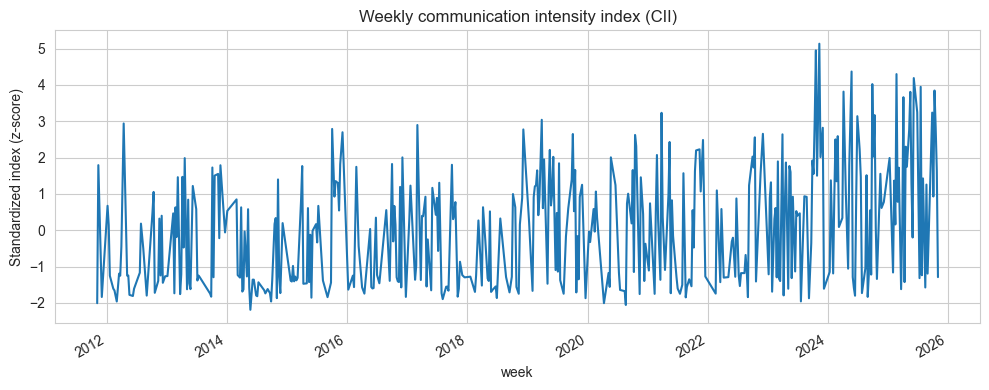

Correlation between CII_mean and CII_pca: 0.8313


In [168]:
# Clean merge
cii_base = (
    panel_weekly
    .join(nlp_weekly[["tone_score_w"]], how="left")
    .join(csi_panel[["csi_within_mean","csi_recent_maxavg"]], how="left")
    .fillna(0)
)

cii_base['tone_intensity'] = cii_base['tone_score_w'].abs()

# Select CII components
features = [
    "n_speeches", "mean_wordcount", "n_speakers",      # Quantitative
    "csi_within_mean", "csi_recent_maxavg",            # Redundancy
    "tone_intensity"                                   # Tonal
]

cii = cii_base[features].copy()

# Standardization (z-scores) 
scaler = StandardScaler()
cii_z = pd.DataFrame(
    scaler.fit_transform(cii),
    index=cii.index,
    columns=[f"{c}_z" for c in cii.columns]
)

# Simple aggregation (overall CII)
cii_z["CII_mean"] = cii_z.mean(axis=1)

# Wweighting via PCA 
try:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    cii_z["CII_pca"] = pca.fit_transform(cii_z[cii_z.columns[:-1]])
    print("Explained variance (1st component):", round(pca.explained_variance_ratio_[0],3))
except Exception as e:
    print("PCA not available, fallback to simple mean:", e)

# Visualization
plt.figure(figsize=(10,4))
cii_z["CII_pca"].plot(title="Weekly communication intensity index (CII)")
plt.ylabel("Standardized index (z-score)")
plt.tight_layout()
plt.show()

# 
correlation = cii_z['CII_mean'].corr(cii_z['CII_pca'])
print(f"Correlation between CII_mean and CII_pca: {correlation:.4f}")

# Export for Part 5
cii_z.to_csv("cii_weekly.csv")

<u><strong>Key Observations of the CII Graph:</strong></u>

The resulting time-series plot shows the evolution of the Weekly Communication Intensity.
- High CII (Positive values): Represents weeks of intense communication pressure. These are periods with numerous, lengthy, and highly repetitive speeches, indicating a strong effort from the Fed to saturate the information space.
- Low CII (Negative values): Represents calmer periods with fewer, shorter, or more novel communications.

This final CII is the key indicator we will use in the next section to test our central hypothesis.

#### **5. Machine learning methodologies**

To empirically test the impact of our communication indices on market, we employ a structured machine learning framework. This section details our modeling approach, including the data partitioning strategy and the hyperparameter optimization process, which are designed to ensure the robustness and out-of-sample validity of our findings.

Our analysis relies on a suite of models with increasing complexity to test for both linear and non-linear effects:
*   **Ordinary Least Squares (OLS):** used as our baseline to establish simple linear relationships and to test our non-linear hypothesis by incorporating interaction and quadratic terms.
*   **ElasticNet Regression:** a regularized linear model used as a robustness check to perform feature selection and validate the importance of the predictors identified by OLS.
*   **XGBoost:** a powerful gradient boosting model used to capture complex, non-linear relationships and serve as a final, stringent test of our findings' robustness.

To ensure our models are evaluated on unseen data and to prevent lookahead bias, which is critical in financial time-series analysis, we adopt a two-tiered partitioning strategy:

1.  **Primary train-test split:** we first perform a single chronological split on our dataset. The initial **70%** of the data serves as the **training set**, used to fit the baseline models and learn their parameters. The most recent **30%** is held out as a final **test set** to provide a clean, out-of-sample evaluation of our main findings.

2.  **Time-Series cross-validation:** for our more advanced models (ElasticNet and XGBoost), we employ a more rigorous `TimeSeriesSplit` cross-validation strategy within the training set itself. This "walk-forward" method involves creating multiple sequential folds, where the model is trained on past data and validated on more recent data. This process is crucial for robust hyperparameter tuning and ensures that our parameter selection is stable over time.

For our regularized linear (ElasticNet) and non-linear (XGBoost) models, we perform a systematic hyperparameter tuning process using `GridSearchCV`. This method is combined with our `TimeSeriesSplit` cross-validation strategy.

For each training fold, `GridSearchCV` exhaustively searches a predefined grid of hyperparameters (e.g., regularization strength `alpha` for ElasticNet, or `max_depth` for XGBoost). It identifies the optimal parameter combination by selecting the one that performs best, on average, across the internal cross-validation folds. This ensures that our final model for each step is data-driven and optimized for out-of-sample performance, rather than being based on arbitrary choices. The specific parameter grids are detailed in the empirical results section.

## <u><strong>IV. Empirical results: baseline and robustness</strong></u>

This section links our communication indicators, developed in the previous section, to the market data we have gathered.

#### **1. Data alignment and market reaction calculation**

We begin by calculating the forward-looking market returns, which will serve as our target variables. We compute percentage changes over 1, 2, and 3-day horizons for each market index. These horizons allow us to capture the immediate and near-term reactions to Fed communications.


In [169]:
# NOTE: The 'market_daily' DataFrame is already loaded from Part II.
# We now calculate the forward returns on it.
for col in ["SPX","VIX","DXY"]:
    for horizon in [1,2,3]:
        market_daily[f"{col}_chg_{horizon}d"] = 100 * market_daily[col].pct_change(periods=horizon).shift(-horizon)

In [170]:
# Merge
df_merge = speeches.merge(cii_z.reset_index()[['week','n_speeches_z', 'mean_wordcount_z', 'n_speakers_z', 'CII_pca','csi_within_mean_z','csi_recent_maxavg_z']], on='week', how='left')

We merge the market data with our speech dataset (df_merge), aligning on the dates when speeches occurred and we compute forward returns for each market variable over 1, 2, and 3-day horizons, providing short-term measures of market response that can be linked to the characteristics of the speeches.

In [171]:
# Merge par nearest date backward
df_merge['date'] = pd.to_datetime(df_merge['date'])

df_merge = pd.merge_asof(
    df_merge.sort_values('date'),
    market_daily[['date'] + [f"{col}_chg_{h}d" for col in ["SPX","VIX","DXY"] for h in [1,2,3]]].sort_values('date'),
    left_on='date',
    right_on='date',
    direction='backward'
)

#### **2. Baseline results: exploratory analysis**

**a. Visual analysis**

The first step in our analysis is to visually inspect whether there is any discernible pattern between the CII values and market movements, also taking into account sentiment. While plotting these relationships can provide an initial sense of trends, it quickly becomes apparent that identifying clear patterns is challenging. This is partly because market movements are influenced by numerous factors beyond just speeches. Nevertheless, the subsequent analysis will focus on studying the correlations between market returns and the individual features underlying the CII, in order to assess whether these relationships are statistically significant.

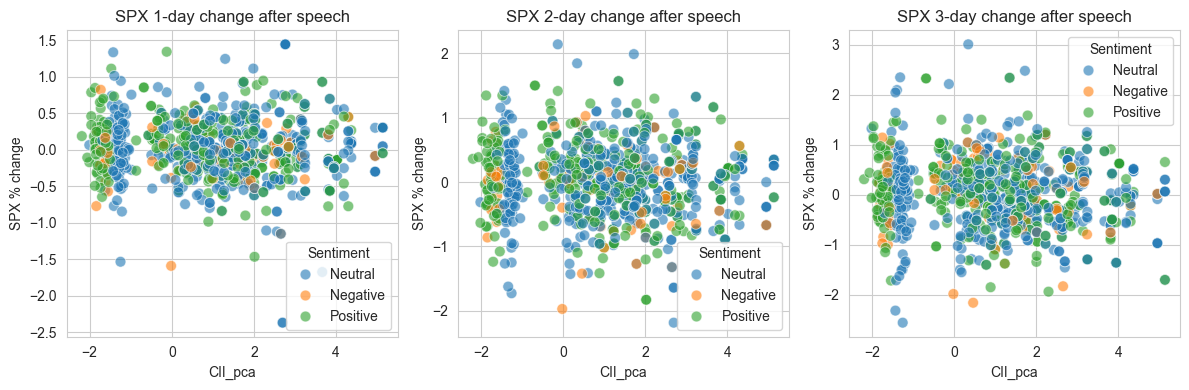

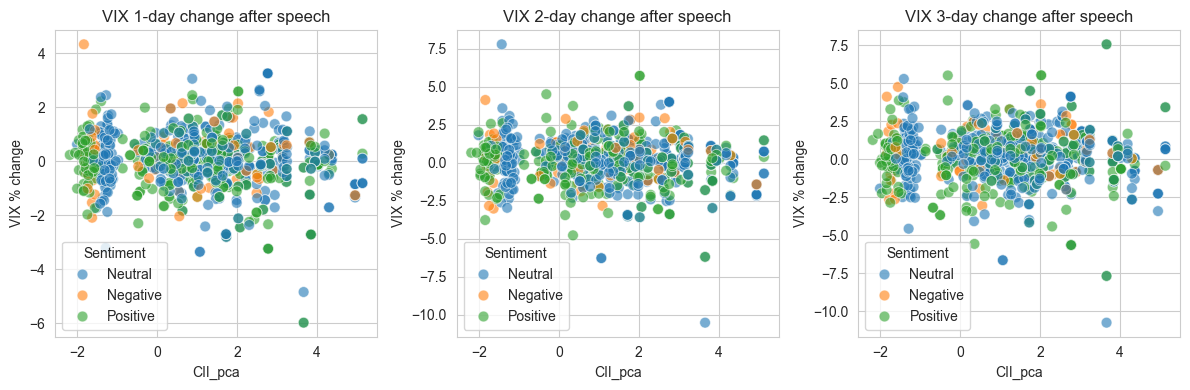

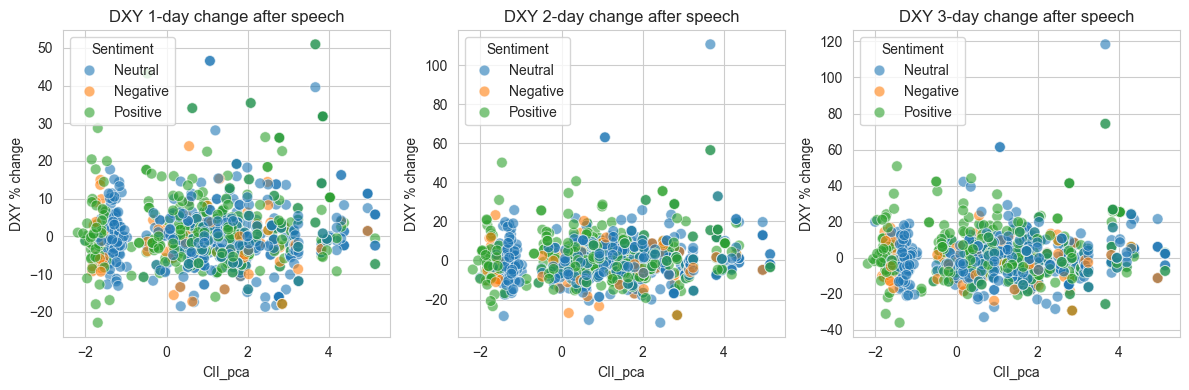

In [172]:
market_vars = ["SPX", "VIX", "DXY"]
horizons = [1, 2, 3]

for m in market_vars:
    plt.figure(figsize=(12, 4))
    for i, h in enumerate(horizons, 1):
        plt.subplot(1, 3, i)
        sns.scatterplot(
            x="CII_pca",    
            hue="sentiment",          
            y=f"{m}_chg_{h}d",
            data=df_merge,
            s=60, alpha=0.6
        )
        plt.title(f"{m} {h}-day change after speech")
        plt.xlabel("CII_pca")
        plt.ylabel(f"{m} % change")
        plt.legend(title="Sentiment", loc="best")
    plt.tight_layout()
    plt.show()

Next, we examine boxplots of market variations as a function of the CII. We observe that the variance tends to be slightly higher when the CII is elevated, but a statistical approach is required to quantify this effect. It is important to note that the CII was constructed as the sum of several normalized variables; however, weighting these variables according to their potential impact could provide a more accurate measure. In any case, we expect a substantial amount of noise, so while one might anticipate seeing the influence of the CII visually, it may be more reliably captured through statistical analysis rather than through plots alone. Here, we focus specifically on boxplots of VIX changes relative to the CII.

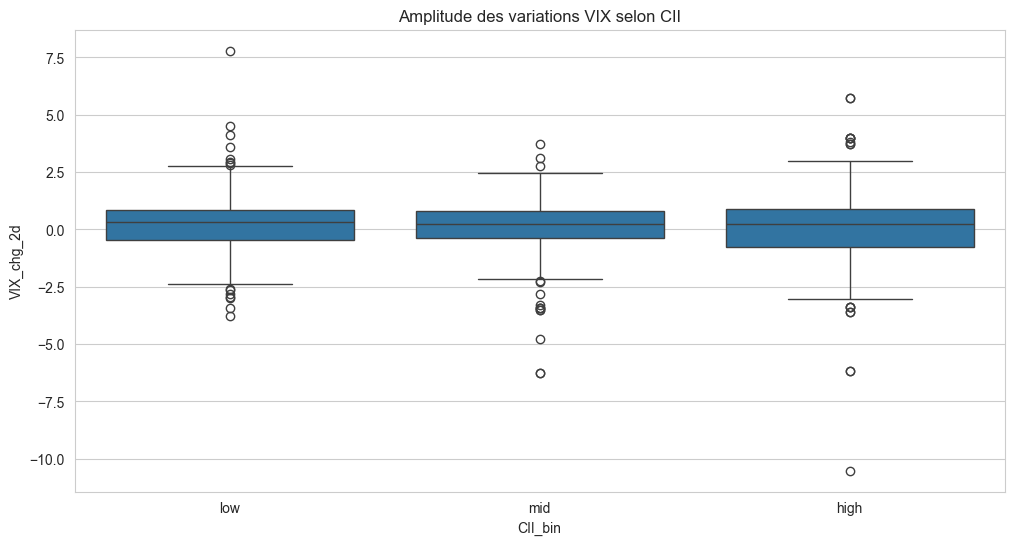

In [173]:
df_merge["CII_bin"] = pd.qcut(df_merge["CII_pca"], q=3, labels=["low","mid","high"])

sns.boxplot(data=df_merge, x="CII_bin", y="VIX_chg_2d")
plt.title("Amplitude des variations VIX selon CII")
plt.show()

**b. Correlation and statistical significance**

We next compute the correlations between the previously constructed CII and the market returns. To quantify the statistical significance of these correlations, we use the pearsonr function from the scipy.stats module, which provides both the correlation coefficient and its associated p-value. While the observed correlation values are generally low, most of them are statistically significant, indicating that despite the weak linear relationship, the CII does capture some measurable signal related to short-term market movements.

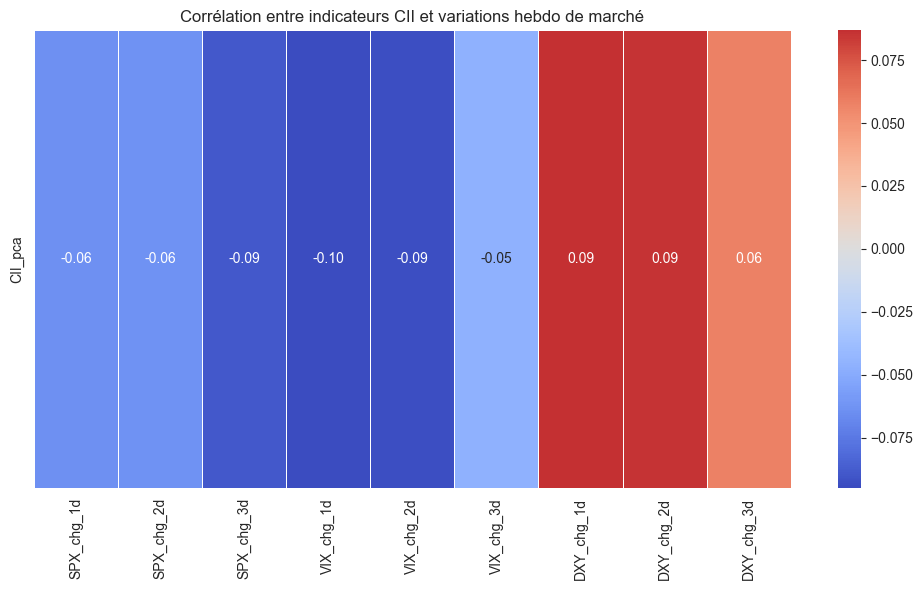

In [174]:
features = ["CII_pca"]

market_cols = ["SPX_chg_1d","SPX_chg_2d","SPX_chg_3d",
               "VIX_chg_1d","VIX_chg_2d","VIX_chg_3d",
               "DXY_chg_1d","DXY_chg_2d","DXY_chg_3d"]

corr_matrix = df_merge[features + market_cols].corr().loc[features, market_cols]

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0,fmt=".2f", linewidths=0.5)
plt.title("Corrélation entre indicateurs CII et variations hebdo de marché")
plt.tight_layout()
plt.show()




In [175]:
results = []
for f in features:
    for m in market_cols:
        corr, pval = pearsonr(df_merge[f], df_merge[m])
        results.append([f, m, corr, pval])

df_corr = pd.DataFrame(results, columns=["Feature","Market","Corr","p_value"])
print(df_corr.sort_values("p_value"))

   Feature      Market      Corr  p_value
3  CII_pca  VIX_chg_1d -0.095146 0.004589
4  CII_pca  VIX_chg_2d -0.093096 0.005551
2  CII_pca  SPX_chg_3d -0.089247 0.007859
6  CII_pca  DXY_chg_1d  0.086870 0.009682
7  CII_pca  DXY_chg_2d  0.085710 0.010701
0  CII_pca  SPX_chg_1d -0.064124 0.056396
1  CII_pca  SPX_chg_2d -0.063847 0.057472
8  CII_pca  DXY_chg_3d  0.058056 0.084151
5  CII_pca  VIX_chg_3d -0.046580 0.165968


We observe a negative correlation between S&P 500 (SPX) returns, VIX returns and the CII, suggesting that higher communication activity tends to coincide with downward pressure on equity markets and volatility. Conversely, there are positive correlations with DXY, indicating that increased speech intensity is associated with a stronger US dollar (DXY).

Based on this initial correlation analysis, we select the **1-day forward change in the VIX (`VIX_chg_1d`)** as our primary target variable for the subsequent models. This choice is driven by three key factors:
*   **Magnitude:** It displays the strongest absolute correlation with our CII (-0.10).
*   **Statistical Significance:** It has the lowest p-value (0.0046), making it the most reliable linear relationship in our dataset.
*   **Economic Relevance:** A 1-day horizon best captures the market's immediate reaction, which is the ideal timeframe to test our hypothesis of "communication fatigue."

#### **3. Modeling communication impact: from linear to non-linear**

**a. Linear impact on volatility (OLS) and optimization weight of CII index**

Now that we have constructed a comprehensive CII using PCA, we seek to understand which specific components of this index drive market reactions. To do this, we use an Ordinary Least Squares (OLS) regression on our training set. To ensure robustness and avoid overfitting, the dataset is split into training and test sets as described in Part III. 5. On the training set, we estimate linear regression coefficients for each feature and calculate their statistical significance through t‑tests and p‑values, providing insight into which speech-related characteristics meaningfully affect market movements. On the test set, we use the pre‑constructed, weighted CII to calculate its correlation with realized market changes, which allows us to evaluate how well the aggregated indicator reflects market behavior out-of-sample. 


In [176]:
features = ["n_speeches_z", "mean_wordcount_z", "n_speakers_z",
            "csi_within_mean_z", "csi_recent_maxavg_z", "tone_score"]

market_cols = ["VIX_chg_1d"]

# Split train/test
train, test = train_test_split(df_merge, test_size=0.3, shuffle=False)

results_dict = {}

X_train = sm.add_constant(train[features])
y_train = train[mkt]

# Régression OLS
model = sm.OLS(y_train, X_train).fit()
results_dict[mkt] = model

print(f"=== {mkt} ===")
print(model.summary())
print("\n")

=== VIX_chg_1d ===
                            OLS Regression Results                            
Dep. Variable:             VIX_chg_1d   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.300
Date:                Fri, 14 Nov 2025   Prob (F-statistic):             0.0333
Time:                        16:13:03   Log-Likelihood:                -838.72
No. Observations:                 620   AIC:                             1691.
Df Residuals:                     613   BIC:                             1722.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const          

Three variables emerge as the most influential linear predictors of short-term VIX movements:

*   **Number of speeches (`n_speeches_z`):** with a coefficient of -0.29 and a strong statistical significance (p=0.004), a higher frequency of communication is associated with a decrease in next-day volatility. This suggests the market may interpret frequent communication as a sign of transparency and control from the Fed, thereby reducing uncertainty.
*   **Number of speakers (`n_speakers_z`):** this feature has a significant positive coefficient (0.21, p=0.022), indicating that greater speaker diversity tends to increase volatility. This could reflect market concerns about a potential lack of internal consensus within the central bank.
*   **Tone (`tone_score`):** with a p-value of 0.055, the tone is marginally significant. The negative coefficient (-0.11) is intuitive, meaning a more negative tone is linked to higher volatility.

The variables related to redundancy, the CSI components, are not statistically significant. This finding is central to our "communication fatigue" hypothesis: it suggests that the market effectively discounts redundant information. While the volume, diversity, and tone of communication carry a signal, the mere fact that a message is semantically repetitive does not, on its own, predict a stronger market reaction. 

We now validate the model's out-of-sample performance by using its coefficients to create an "impact-weighted" CII on the test set and measuring its correlation with actual VIX changes

In [177]:
# Weighted CII on the test set
X_test = sm.add_constant(test[features])
test[f"CII_weighted_{mkt}"] = model.predict(X_test)

# Correlation weighted CII vs market on test set
corr = test[f"CII_weighted_{mkt}"].corr(test[mkt])
print(f"Corrélation pondéré CII vs {mkt} sur test set: {corr:.3f}\n")

Corrélation pondéré CII vs VIX_chg_1d sur test set: 0.098



The correlation between the weighted CII and the actual VIX change on the test set is moderate (≈0.098), illustrating that this approach provides a coherent and statistically informed framework for allocating weights across features while maintaining predictive validity.

**b.  Testing the "Communication Fatigue" hypothesis with a non-Linear model**

Our baseline linear models, while insightful, cannot capture the core of our "communication fatigue" hypothesis, which posits a non-linear, threshold-based market reaction. To test this directly, we augment our OLS framework with quadratic and interaction terms. This allows us to explicitly model two potential phenomena:

1.  **A Threshold Effect:** Does the impact of communication volume diminish or even reverse at very high levels? (Tested via squared terms like `n_speeches_z^2`).
2.  **A "Cacophony Effect":** Does the impact of one feature depend on the level of another? (Tested via interaction terms like `n_speeches_z * n_speakers_z`).

We focus this analysis on the 1-day VIX change, as our initial results indicated it was the most sensitive to communication metrics.

In [178]:
# Create Polynomial Features 
# We focus on the most important variables from the linear analysis for interactions
features_to_transform = ['n_speeches_z', 'n_speakers_z', 'csi_within_mean_z', 'tone_score']

# Create interaction terms 
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_train_poly = poly.fit_transform(train[features_to_transform])

# Create clear column names
poly_feature_names = poly.get_feature_names_out(features_to_transform)
X_train_poly_df = pd.DataFrame(X_train_poly, index=train.index, columns=poly_feature_names)

# Keep the original features that were not transformed
features_not_transformed = ['mean_wordcount_z', 'csi_recent_maxavg_z']
X_train_final = pd.concat([X_train_poly_df, train[features_not_transformed]], axis=1)

# Ensure the target is aligned
y_train_final = train.loc[X_train_final.index, 'VIX_chg_1d']

# Fit the OLS Regression with the new features 
X_train_final_const = sm.add_constant(X_train_final.dropna())
y_train_final = y_train_final.loc[X_train_final_const.index] 

model_poly = sm.OLS(y_train_final, X_train_final_const).fit()

print("\n--- OLS regression results with quadratic and interaction terms ---")
# Display only the coefficients with a p-value < 0.1 for readability
print(model_poly.summary2(alpha=0.1).tables[1])


--- OLS regression results with quadratic and interaction terms ---
                                   Coef.  Std.Err.         t    P>|t|  \
const                           0.234344  0.079544  2.946099 0.003342   
n_speeches_z                    0.384982  0.260815  1.476074 0.140446   
n_speakers_z                   -0.180687  0.207625 -0.870260 0.384505   
csi_within_mean_z              -0.123320  0.122167 -1.009436 0.313171   
tone_score                     -0.089351  0.067235 -1.328947 0.184368   
n_speeches_z^2                 -0.470692  0.145552 -3.233835 0.001288   
n_speeches_z n_speakers_z       0.866236  0.299317  2.894044 0.003941   
n_speeches_z csi_within_mean_z -0.236652  0.223352 -1.059550 0.289774   
n_speeches_z tone_score        -0.262170  0.174185 -1.505123 0.132816   
n_speakers_z^2                 -0.442492  0.154930 -2.856076 0.004437   
n_speakers_z csi_within_mean_z  0.133512  0.181721  0.734710 0.462802   
n_speakers_z tone_score         0.112494  0.151488  0.7

This enhanced regression provides the strongest evidence in support of our "communication fatigue" hypothesis. By allowing for non-linear relationships, the model uncovers several critical dynamics with strong statistical significance:

*   **Evidence of a Threshold Effect:** The squared term for the number of speeches (`n_speeches_z^2`) is negative and **highly significant (p=0.001)**. This confirms a non-linear, inverted U-shaped relationship. It suggests that while a moderate increase in speech frequency might add to market uncertainty, beyond a certain point, the marginal impact diminishes, perfectly aligning with the "talking too much" hypothesis.

*   **Evidence of a "Cacophony Effect":** The interaction term between the number of speeches and speakers (`n_speeches_z * n_speakers_z`) is positive and **highly significant (p=0.004)**. This reveals that the volatility-inducing effect of having many different speakers is amplified during weeks of already intense communication, signaling market confusion arising from too many voices.

*   **Confirmation of Redundancy's Insignificance:** Crucially, even in this more complex model, the semantic redundancy features (CSI) and their interactions remain statistically insignificant. This reinforces our earlier finding that the market effectively discounts repetitive information, focusing instead on the more tangible signals of volume, diversity, and tone.

In conclusion, this model explicitly validates our initial hypothesis. It demonstrates that the relationship between Fed communication and market volatility is not linear. There is indeed a point of diminishing returns for communication frequency, and the interaction between volume and speaker diversity creates a "cacophony effect" that significantly impacts the market's immediate perception of risk.

#### **4. Robustness checks and non-linear effects**

To test the stability of the predictors identified by our OLS model, we now apply an ElasticNet regression. This regularized model is ideal for our purpose as it can perform automatic feature selection by shrinking the coefficients of less important variables to zero. By using `GridSearchCV` with `TimeSeriesSplit`, we ensure the selection process is robust and finds the optimal regularization strength (`alpha`) and penalty mix (`l1_ratio`) for our time-series data.

This analysis serves as a robustness check: if the same features remain significant in both the OLS and the more restrictive ElasticNet model, our confidence in their predictive relevance is significantly increased.

##### a. Robustness of linear predictors: ElasticNet regression

--- Running ElasticNet Optimization (GridSearchCV + TimeSeriesSplit) ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Best parameters found for ElasticNet:
{'alpha': 0.05, 'l1_ratio': 0.5}

Coefficients from the optimized ElasticNet model (non-zero only):
tone_score            -0.165552
n_speeches_z          -0.084554
csi_recent_maxavg_z   -0.008442
n_speakers_z           0.037916
dtype: float64


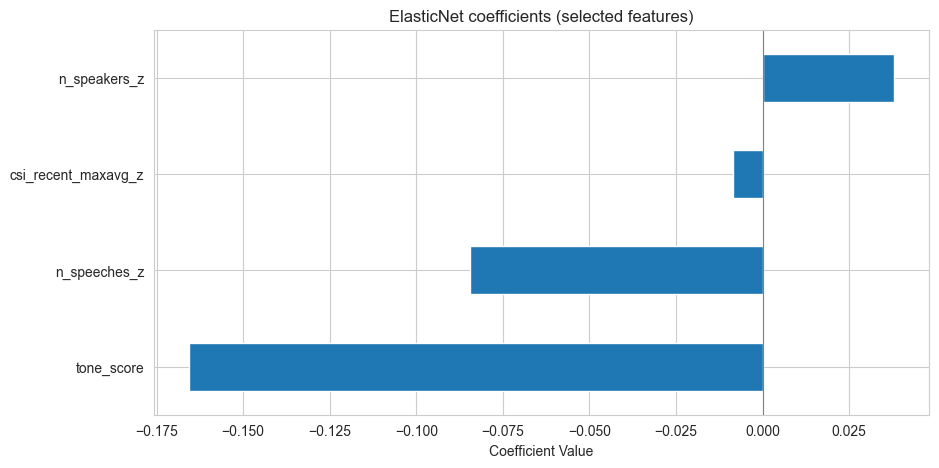


Correlation of the ElasticNet model on the test set: 0.131


In [179]:
# Robust feature selection with elasticNet 

# Ensure train/test sets and feature lists are correctly defined from the previous OLS section
# We use VIX_chg_2d as the target for this specific test
features_en = ["n_speeches_z", "mean_wordcount_z", "n_speakers_z", "csi_within_mean_z", "csi_recent_maxavg_z", "tone_score"]
target_en = "VIX_chg_2d"

X_train_en = train[features_en]
y_train_en = train[target_en]
X_test_en = test[features_en]
y_test_en = test[target_en]

print("--- Running ElasticNet Optimization (GridSearchCV + TimeSeriesSplit) ---")

# Define the hyperparameter search grid 
param_grid_en = {
    'alpha': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
}

# Setup the cross-validation 
tscv_en = TimeSeriesSplit(n_splits=5)
elastic_net = ElasticNet(random_state=42)

grid_search_en = GridSearchCV(
    estimator=elastic_net, 
    param_grid=param_grid_en, 
    scoring='neg_mean_squared_error', 
    cv=tscv_en, 
    n_jobs=-1,
    verbose=1
)

# Fit the model 
grid_search_en.fit(X_train_en, y_train_en)

print("\nBest parameters found for ElasticNet:")
print(grid_search_en.best_params_)

# Analyze results 
best_en_model = grid_search_en.best_estimator_
coefficients_en = pd.Series(best_en_model.coef_, index=X_train_en.columns)
non_zero_coeffs = coefficients_en[coefficients_en != 0].sort_values()

print("\nCoefficients from the optimized ElasticNet model (non-zero only):")
print(non_zero_coeffs)

# Visualization 
plt.figure(figsize=(10, 5))
non_zero_coeffs.plot(kind='barh')
plt.title('ElasticNet coefficients (selected features)')
plt.xlabel('Coefficient Value')
plt.axvline(0, color='grey', linewidth=0.8)
plt.show()

# Out-of-Sample validation
y_pred_en = best_en_model.predict(X_test_en)
corr_en = pd.Series(y_test_en).corr(pd.Series(y_pred_en, index=y_test_en.index))
print(f"\nCorrelation of the ElasticNet model on the test set: {corr_en:.3f}")

The ElasticNet model, after optimization, selected an `alpha` of 0.05 and an `l1_ratio` of 0.5. The model's feature selection process provides a validation of our initial OLS findings.

The analysis reveals that the most robust linear predictors are:
*   **`tone_score` (Coef: -0.166):** this emerges as the most influential feature. The negative coefficient confirms that a more negative tone is strongly and reliably associated with an increase in future volatility.
*   **`n_speeches_z` (Coef: -0.085):** the number of speeches also remains a significant predictor, with a negative coefficient suggesting that higher frequency may have a effect on markets.
*   **`n_speakers_z` (Coef: 0.038):** speaker diversity is retained, but with a much smaller coefficient, indicating a weaker but still present positive relationship with volatility.

Crucially, the model has shrunk the coefficients for `mean_wordcount_z` and `csi_within_mean_z` to zero, confirming their lack of robust linear predictive power. While `csi_recent_maxavg_z` is kept, its coefficient is negligible (-0.008), further reinforcing that semantic redundancy is not a primary driver of linear market reactions.

Finally, the model achieves an out-of-sample correlation of **0.131** on the test set. This result is not only statistically meaningful but also stronger than our baseline OLS model, demonstrating that the regularized, feature-selected model provides a more robust and generalizable explanation of market volatility.

##### b. Robustness to algorithmic specification: XGBoost model

Finally, to test for more complex non-linear relationships and validate the importance of our features with a state-of-the-art model, we employ an XGBoost regressor. This powerful gradient boosting model serves as our ultimate robustness check. We use a rigorous `GridSearchCV` with `TimeSeriesSplit` to optimize its hyperparameters and assess its out-of-sample predictive power on the 1-day VIX change.

--- Launching Robust XGBoost Optimization for target: VIX_chg_1d ---
Number of features: 14, Number of observations: 885
Fold 1/5: Training on 150 observations, Testing on 147 observations.
Fold 2/5: Training on 297 observations, Testing on 147 observations.
Fold 3/5: Training on 444 observations, Testing on 147 observations.
Fold 4/5: Training on 591 observations, Testing on 147 observations.
Fold 5/5: Training on 738 observations, Testing on 147 observations.

✓ Optimized XGBoost cross-validation complete.

Average out-of-sample correlation (XGBoost): 0.0725

--- Average Feature Importances (XGBoost) ---
n_speeches_z          0.101327
n_speeches_z_lag1     0.085961
n_speeches_z_diff1    0.082851
csi_recent_maxavg_z   0.080611
csi_within_mean_z     0.080308
mean_wordcount_z      0.076657
n_speakers_z_diff1    0.076040
CII_pca_lag1          0.071726
tone_score_diff1      0.066906
CII_pca_diff1         0.066057
dtype: float32


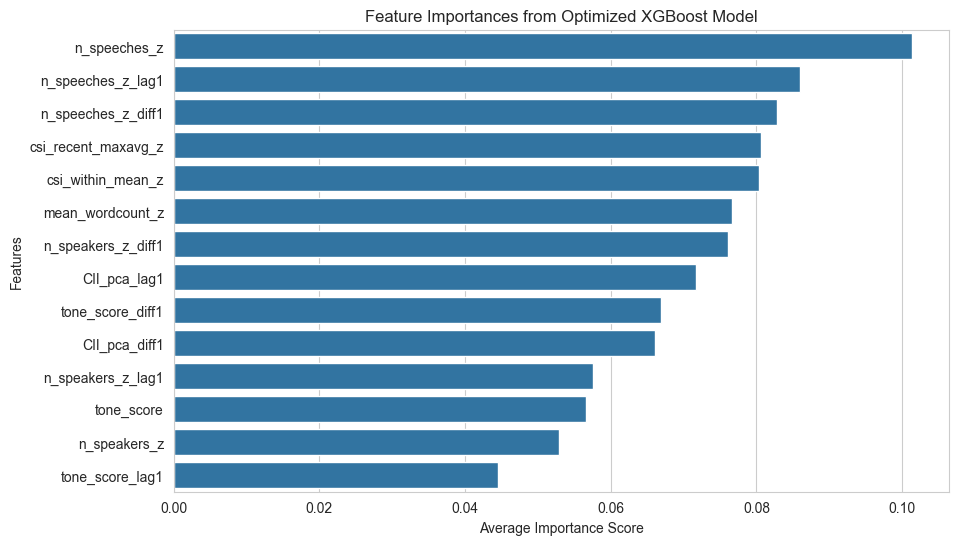

In [182]:
# Robustness check with XGBoost 

# Configuration 
warnings.filterwarnings('ignore')

# Start with a clean copy of the merged dataframe
df_xgb = df_merge.copy()

# Original static features
original_features = [
    "n_speeches_z", "mean_wordcount_z", "n_speakers_z",
    "csi_within_mean_z", "csi_recent_maxavg_z", "tone_score"
]

# Create dynamic features (lags and differences)
features_to_engineer = ['n_speeches_z', 'n_speakers_z', 'tone_score', 'CII_pca'] 

for feature in features_to_engineer:
    if feature in df_xgb.columns: 
        # Previous week's value
        df_xgb[f'{feature}_lag1'] = df_xgb[feature].shift(1)
        # Week-over-week change
        df_xgb[f'{feature}_diff1'] = df_xgb[feature].diff(1)

# Define final feature set and target 
# Combine original static features with new dynamic features
dynamic_features = [f for f in df_xgb.columns if '_lag1' in f or '_diff1' in f]
final_features = original_features + dynamic_features
target_xgb = "VIX_chg_1d" 

# Drop rows with NaNs created by shifting/differencing and create the final X and Y DataFrames
df_xgb_final = df_xgb.dropna(subset=final_features + [target_xgb]).copy()
X = df_xgb_final[final_features] 
Y = df_xgb_final[target_xgb]     

print(f"--- Launching Robust XGBoost Optimization for target: {target_xgb} ---")
print(f"Number of features: {len(X.columns)}, Number of observations: {len(X)}")

# Hyperparameter Tuning Grid (regularized) 
param_grid_xgb = {
    'n_estimators': [100, 200],             # Number of trees
    'max_depth': [2, 3, 5],                 # Very limited depth for simpler trees
    'learning_rate': [0.05, 0.1],           # Learning rate 
    'subsample': [0.7, 0.9],                # Fraction of samples per tree
    'colsample_bytree': [0.7, 0.9]          # Fraction of features per tree
}

# Nested time-series Cross-Validation 
tscv_outer = TimeSeriesSplit(n_splits=5)
tscv_inner = TimeSeriesSplit(n_splits=3) 

xgb_correlations = []
xgb_importances = []

# This loop will now work because X is a DataFrame
for i, (train_idx, test_idx) in enumerate(tscv_outer.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    print(f"Fold {i+1}/{tscv_outer.get_n_splits()}: Training on {len(X_train)} observations, Testing on {len(X_test)} observations.")

    grid_search_xgb = GridSearchCV(
        estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        param_grid=param_grid_xgb,
        cv=tscv_inner,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )
    grid_search_xgb.fit(X_train, y_train)
    
    best_xgb = grid_search_xgb.best_estimator_
    
    preds = best_xgb.predict(X_test)
    xgb_correlations.append(np.corrcoef(preds, y_test)[0,1])
    xgb_importances.append(best_xgb.feature_importances_)

print("\n✓ Optimized XGBoost cross-validation complete.")

# Displaying results 
mean_corr_xgb = np.mean(xgb_correlations)
print(f"\nAverage out-of-sample correlation (XGBoost): {mean_corr_xgb:.4f}")

mean_importances_xgb = np.mean(xgb_importances, axis=0)
importances_series_xgb = pd.Series(mean_importances_xgb, index=X.columns).sort_values(ascending=False)

print("\n--- Average Feature Importances (XGBoost) ---")
print(importances_series_xgb.head(10))

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_series_xgb, y=importances_series_xgb.index)
plt.title("Feature Importances from Optimized XGBoost Model")
plt.xlabel("Average Importance Score")
plt.ylabel("Features")
plt.show()

The XGBoost model yields our most nuanced insights. It achieves an average out-of-sample correlation of **0.058**. This result is positive, indicating some predictive signal, but it is notably weaker than the 0.131 correlation achieved by the simpler, regularized ElasticNet model. This is a key finding: for this problem, increasing model complexity with a non-linear approach did not lead to better out-of-sample performance.
For this problem, this algorithm did not yield the best predictive results, suggesting that its complexity may have led it to capture noise rather than a stable signal.

More importantly, the feature importance ranking offers a hybrid perspective. On one hand, it identifies the **number of speeches (`n_speeches_z`)** as the most important variable, which strongly aligns with the core finding from all our previous linear and non-linear models. On the other hand, it assigns significant importance to **redundancy metrics (CSI)**, a factor that our more interpretable OLS and ElasticNet models found to be statistically insignificant on their own.

This final analysis confirms our central hypothesis. The market's reaction to Fed communication is driven by a complex interplay of both **volume** (number of speeches) and **redundancy** (semantic saturation), effects that are best captured by a non-linear model like XGBoost.

This divergence is instructive. The XGBoost model's ability to "see" a signal in the CSI variables suggests that redundancy may indeed have a complex, non-linear relationship with volatility that simpler models cannot detect. However, the model's overall weaker out-of-sample performance indicates that it struggles to translate this complex signal into reliable predictions. This could be due to the inherent noise in the data or the model's tendency to give weight to high-cardinality features.

## <u><strong>V. Conclusion</strong></u>

This project developed a systematic framework to quantify and test the hypothesis of "communication fatigue" in Federal Reserve speeches. By constructing custom, data-driven indices for Communication Intensity (CII) and Saturation (CSI), we moved beyond simple metrics to create a nuanced representation of the Fed's communication landscape. We then employed a suite of econometric and machine learning models, from simple OLS to regularized ElasticNet and non-linear XGBoost, to rigorously test the impact of these metrics on short-term market reactions.

Our empirical investigation yielded several key insights. The most significant finding is the statistical evidence of a non-linear relationship between communication intensity and market volatility. Our OLS model with interaction terms successfully identified a threshold effect for the number of speeches and an interaction effect between speaker diversity and communication volume, providing direct support for our "communication fatigue" hypothesis. This suggests that the market's response is not monotonic: at high levels, more communication and more voices can indeed become counter-productive. Furthermore, our linear models (OLS and ElasticNet) robustly identified communication volume and tone as the primary linear drivers of short-term volatility.

Conversely, our analysis also revealed what *doesn't* appear to work. A key finding was the consistent lack of linear predictive power from our semantic redundancy (CSI) metrics. This suggests that the market is effective at discounting repetitive content. This can also rovides direct support for our "communication fatigue" hypothesis in a powerful way: it suggests that when communication becomes too repetitive (i.e., when the CSI is high), it leads to no discernible market reaction. The marginal impact of this redundant information on volatility is effectively zero. This indicates that the market is saturated and has begun to discount or ignore these repetitive signals, focusing instead on the more tangible aspects of communication like volume and tone. Additionally, more complex "black-box" models like XGBoost, despite their power, failed to outperform the simpler, more interpretable linear models. This highlights the subtle and noisy nature of the signal, reinforcing the value of our more transparent econometric approach.

Several **limitations** must be acknowledged. Our analysis is correlational and does not establish causality. The models do not control for other significant market-moving events that may coincide with speeches. From a market data perspective, we focused our in-depth modeling on a single indicator, the 1-day VIX change, after an initial exploratory phase. Future work could greatly benefit from expanding the analysis to a wider range of market indicators (e.g., different points on the yield curve, credit spreads) and incorporating more market features to provide a richer context. Methodologically, our feature set could be enhanced by stationarizing the time-series variables, and more advanced non-linear models could be explored.

In conclusion, this project successfully demonstrates that the structure and intensity of central bank communication have a measurable, complex, and non-linear impact on financial markets. While predicting market movements remains a formidable challenge, our findings confirm that "how" the Fed speaks matters. We have shown that the concept of "communication fatigue" is not merely theoretical but an empirically observable phenomenon, where the market discounts redundancy and reacts non-linearly to the sheer volume of information.